In [1]:
import graphlab as gl
import pandas as pd
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

product_elec_rating_stats_samsung_sorted_shortlist=gl.load_sframe('./product_elec_rating_stats_samsung_sorted_shortlist')

[INFO] Could not import Theano, will use standard float for default ShardedCorpus dtype.
[INFO] This trial license of GraphLab Create is assigned to revanthg@hotmail.com and will expire on July 10, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-366 - Server binary: /Users/revanthgarlapati/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1434912241.log
[INFO] GraphLab Server Version: 1.4.1


In [2]:
elec_rev_data= gl.load_sframe('./elec_rev_data_new/')
elec_rev_data=elec_rev_data.unpack('X1',column_name_prefix='')

In [3]:
#compute the cumulative months column
product_elec_rating_stats_samsung_sorted_shortlist['cumulativemonths']=12*product_elec_rating_stats_samsung_sorted_shortlist['reviewyear']+product_elec_rating_stats_samsung_sorted_shortlist['reviewmonth']

In [4]:
product_elec_rating_stats_samsung_sorted_shortlist.head()

asin,reviewmonth,reviewyear,Count,Avg of overall,Stdv of overall,Total review count,Total review months
B004CGHDEO,12,2010,1,5.0,0.0,1152,42
B004CGHDEO,1,2011,1,4.0,0.0,1152,42
B004CGHDEO,2,2011,1,3.0,0.0,1152,42
B004CGHDEO,3,2011,1,5.0,0.0,1152,42
B004CGHDEO,6,2011,1,1.0,0.0,1152,42
B004CGHDEO,7,2011,1,5.0,0.0,1152,42
B004CGHDEO,8,2011,3,4.66666666667,0.471404520791,1152,42
B004CGHDEO,9,2011,8,4.875,0.330718913883,1152,42
B004CGHDEO,10,2011,7,4.57142857143,0.728431359085,1152,42
B004CGHDEO,11,2011,6,4.83333333333,0.37267799625,1152,42


In [5]:
#filtering the products with Tital review count less than 500 

product_elec_rating_stats_samsung_sorted_shortlist=product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['Total review count']>500]

product_elec_rating_stats_samsung_sorted_shortlist.print_rows(1000)



+------------+-------------+------------+-------+----------------+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall |
+------------+-------------+------------+-------+----------------+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  |
| B004CGHDEO |      12     |    2011    |   11  | 4.18181818182  |
| B004CGHDEO |      1      |    2012    |   7   | 3.5714285714

In [6]:
##getting a unique list of samsung prodcuts of interest
samsung_product_short_list=list(set(list(product_elec_rating_stats_samsung_sorted_shortlist['asin'])))

In [7]:
cnt=0
extremenegslope=-0.25
extremeposslope=0.25
def my_neg_condition(x):
    return x <extremenegslope
def my_pos_condition(x):
    return x >extremeposslope
neg_count_item=[]
pos_count_item=[]
for itemid,item in enumerate(samsung_product_short_list):
    itemframe = product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] == item]
    rating_list=list(itemframe['Avg of overall'])
    cumulative_month_list=list(itemframe['cumulativemonths'])
    item_slopes=[]
    for i in range(0, len(cumulative_month_list)-1): 
        item_slopes.append((rating_list[i+1]-rating_list[i])/float(cumulative_month_list[i+1]-cumulative_month_list[i]))
       
    neg_count_item.append(sum(map(my_neg_condition, item_slopes))/float(len(item_slopes)))
    pos_count_item.append(sum(map(my_pos_condition, item_slopes))/float(len(item_slopes)))

neg_count_item=[i*100 for i in neg_count_item]
pos_count_item=[i*100 for i in pos_count_item]
print neg_count_item
print 
print pos_count_item


[8.333333333333332, 26.08695652173913, 9.090909090909092, 12.5, 24.137931034482758, 0.0, 37.5, 27.27272727272727, 41.46341463414634, 22.58064516129032, 29.166666666666668, 12.5, 7.142857142857142, 15.384615384615385, 31.25, 8.333333333333332, 16.666666666666664, 0.0, 14.285714285714285, 28.947368421052634]

[16.666666666666664, 17.391304347826086, 22.727272727272727, 21.875, 20.689655172413794, 5.0, 22.916666666666664, 27.27272727272727, 36.58536585365854, 25.806451612903224, 20.833333333333336, 18.75, 17.857142857142858, 15.384615384615385, 18.75, 8.333333333333332, 8.333333333333332, 8.333333333333332, 9.523809523809524, 28.947368421052634]


In [8]:
#finding top 5 products with more percentage negative slopes

items_of_int_n=sorted(range(len(neg_count_item)), key=lambda i: neg_count_item[i], reverse=True)[:5]

print neg_count_item[items_of_int_n[0]]
print neg_count_item[items_of_int_n[1]]
print neg_count_item[items_of_int_n[2]]
print neg_count_item[items_of_int_n[3]]
print neg_count_item[items_of_int_n[4]]

41.4634146341
37.5
31.25
29.1666666667
28.9473684211


In [9]:
#finding top 5 products with more percentage positive slopes
items_of_int_p=sorted(range(len(pos_count_item)), key=lambda i: pos_count_item[i], reverse=True)[:5]

print pos_count_item[items_of_int_p[0]]
print pos_count_item[items_of_int_p[1]]
print pos_count_item[items_of_int_p[2]]
print pos_count_item[items_of_int_p[3]]
print pos_count_item[items_of_int_p[4]]

36.5853658537
28.9473684211
27.2727272727
25.8064516129
22.9166666667


In [10]:
print 'top negative items'
for i in items_of_int_n:
    print samsung_product_short_list[i]
print 
print 'top positive items'
for i in items_of_int_p:
    print samsung_product_short_list[i]



top negative items
B004CGHDEO
B0079KZZKO
B00BFDHVAS
B0080CXSOU
B004DBD4TG

top positive items
B004CGHDEO
B004DBD4TG
B008AJLPYS
B005VFG06W
B0079KZZKO


In [11]:
##reading meta data to identify product names
elec_meta_data=gl.load_sframe('./elec_meta_data_new/')
elec_meta_data = elec_meta_data.unpack('X1', column_name_prefix='')

In [12]:
print 'top negative item names'
n_item_title_list=[]
p_item_title_list=[]
for i in items_of_int_n:   
    item_title_n= elec_meta_data[elec_meta_data['asin']==samsung_product_short_list[i] ]['title']
    print samsung_product_short_list[i]
    print item_title_n
    n_item_title_list.append(item_title_n)
print 
print 'top positive item names'
for i in items_of_int_p:
    item_title_p= elec_meta_data[elec_meta_data['asin']==samsung_product_short_list[i] ]['title']
    print samsung_product_short_list[i]
    print item_title_p
    p_item_title_list.append(item_title_p)

top negative item names
B004CGHDEO
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', ... ]
B0079KZZKO
['Samsung WIS12ABGNX Wireless LAN Adapter', ... ]
B00BFDHVAS
['Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', ... ]
B0080CXSOU
['Adapter HDMI EPL 3FHU for Samsung Galaxy s3', ... ]
B004DBD4TG
['Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', ... ]

top positive item names
B004CGHDEO
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', ... ]
B004DBD4TG
['Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', ... ]
B008AJLPYS
['Samsung Ultra Portable Slim DVD+/-RW USB External Drive, Black SE-218BB/RSBS', ... ]
B005VFG06W
['Komputerbay 64GB Class 10 UHS-1 Grade 1 70MB/s MicroSDXC Pro Memory Card using Samsung NAND with Komputerbay SD Adapter', ... ]
B0079KZZKO
['Samsung WIS12ABGNX Wireless LAN Adapter', ... ]


In [13]:
#run it only once to convert sframes to lists
temp=[item[0] for item in n_item_title_list]
n_item_title_list=temp

temp=[item[0] for item in p_item_title_list]
p_item_title_list=temp

print n_item_title_list
print p_item_title_list

['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung WIS12ABGNX Wireless LAN Adapter', 'Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', 'Adapter HDMI EPL 3FHU for Samsung Galaxy s3', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)']
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)', 'Samsung Ultra Portable Slim DVD+/-RW USB External Drive, Black SE-218BB/RSBS', 'Komputerbay 64GB Class 10 UHS-1 Grade 1 70MB/s MicroSDXC Pro Memory Card using Samsung NAND with Komputerbay SD Adapter', 'Samsung WIS12ABGNX Wireless LAN Adapter']


In [14]:
print len(n_item_title_list)
print n_item_title_list
len(items_of_int_n)
print items_of_int_n

5
['Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black', 'Samsung WIS12ABGNX Wireless LAN Adapter', 'Samsung BD-F5900 3D Wi-Fi Blu-ray Disc Player (2013 Model)', 'Adapter HDMI EPL 3FHU for Samsung Galaxy s3', 'Samsung Galaxy Tab Data Cable (Charging) USB to 30 Pin (ECC1DP0UBEGSTA)']
[8, 6, 14, 10, 19]


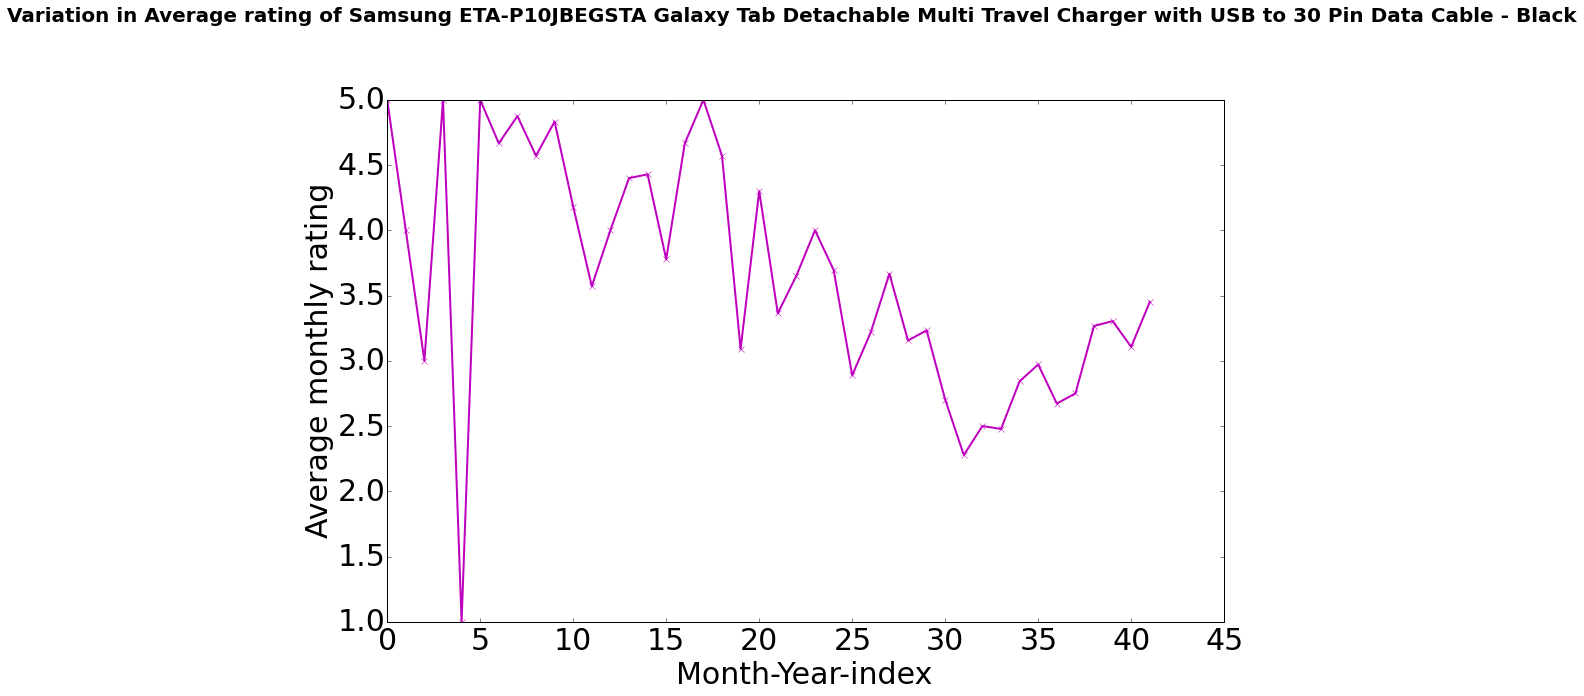

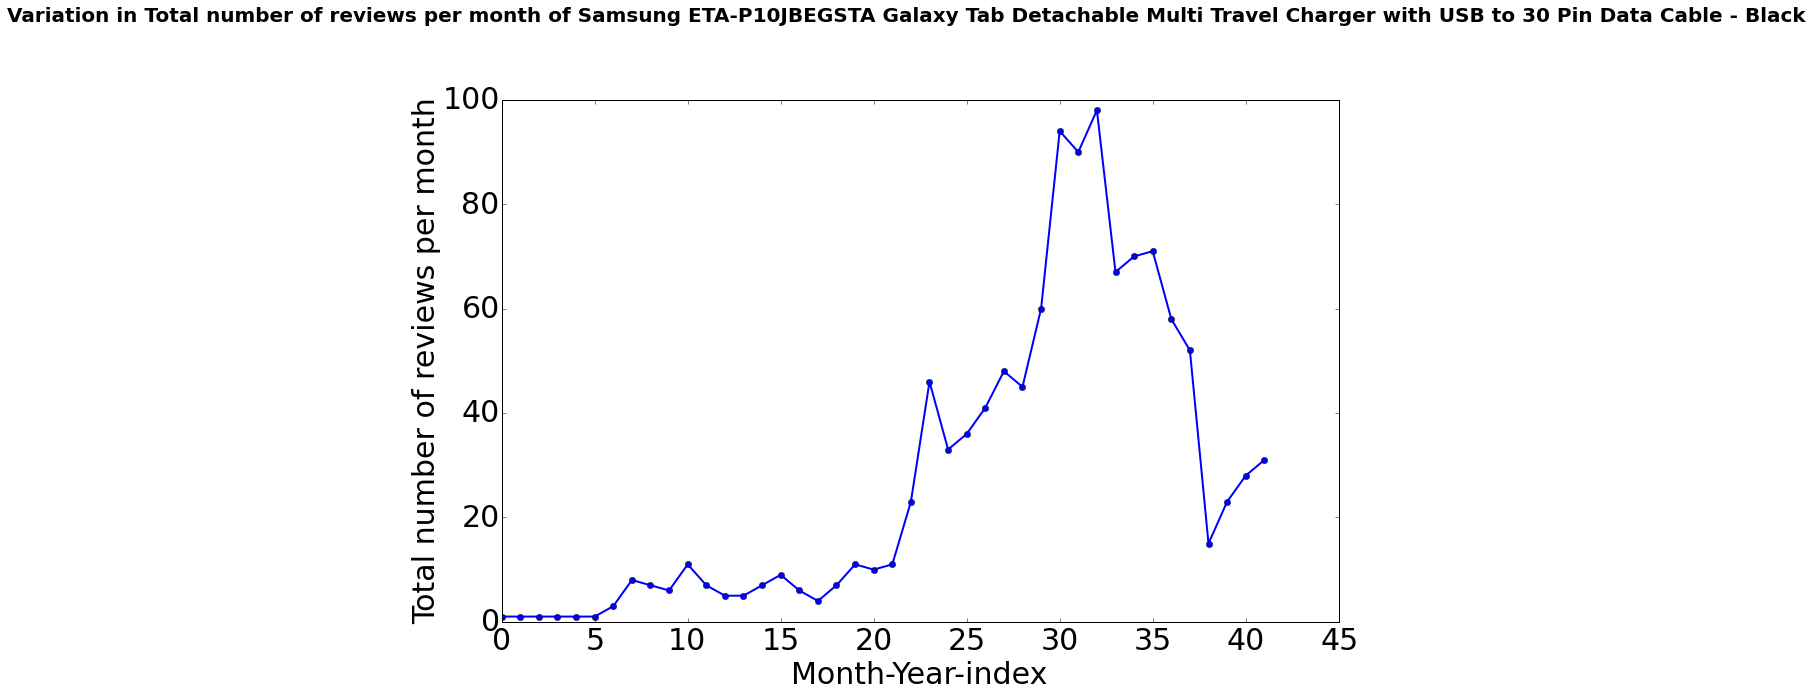

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       | ... |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       | ... |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       | ... |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       | ... |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  | ... |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      | ... |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  | ... |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  | ... |
| B004CGHDEO |      12     |    2011    |   11  | 4

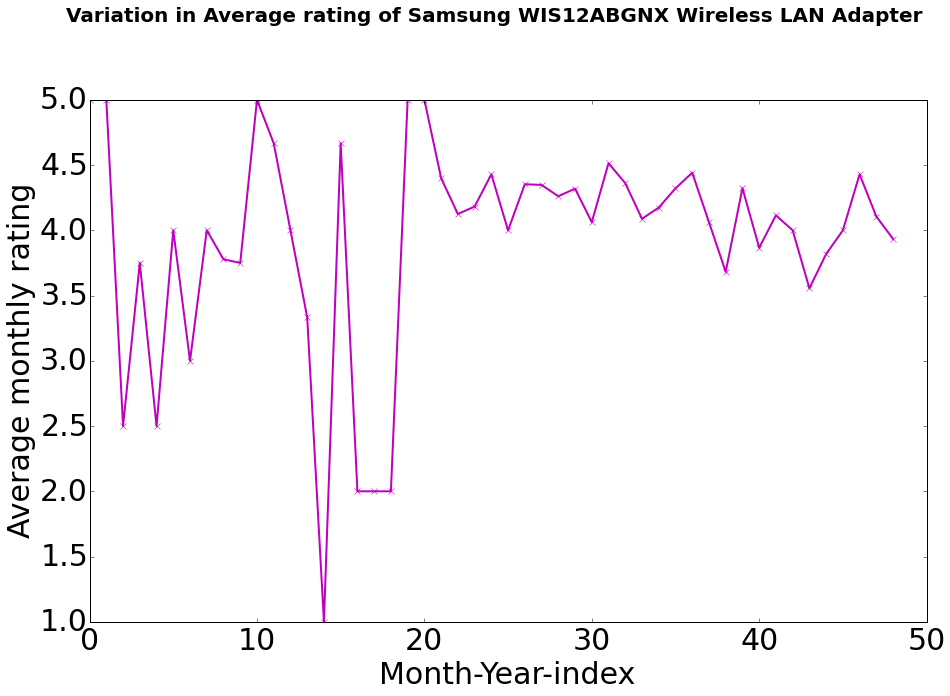

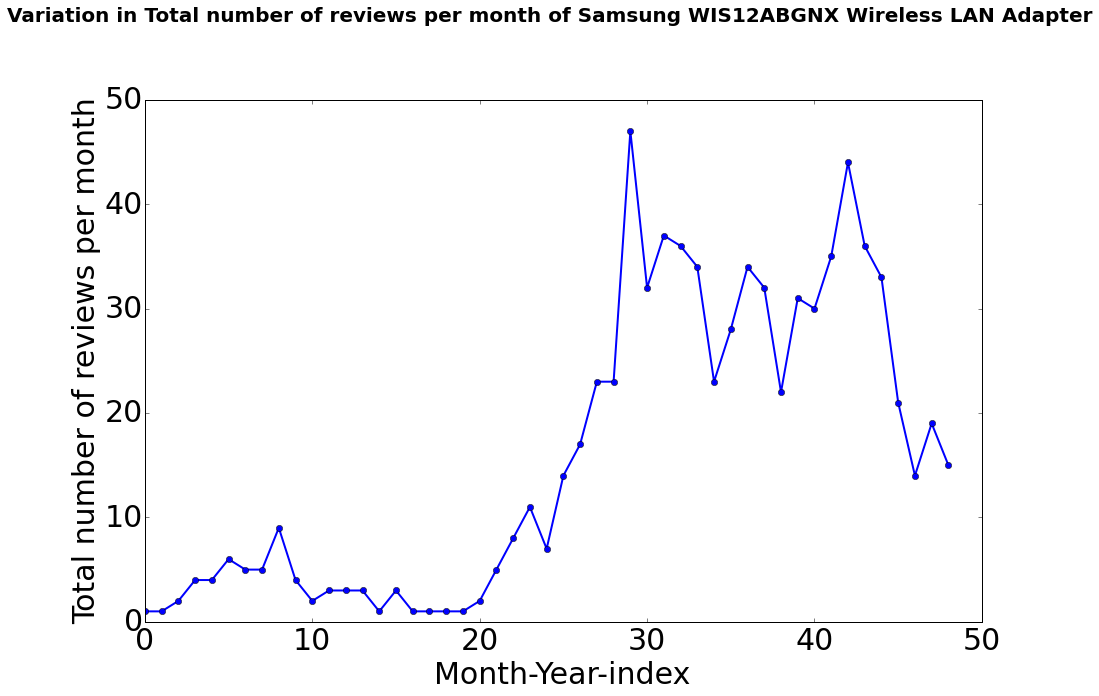

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0079KZZKO |      4      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      5      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      6      |    2010    |   2   |      2.5       | ... |
| B0079KZZKO |      7      |    2010    |   4   |      3.75      | ... |
| B0079KZZKO |      8      |    2010    |   4   |      2.5       | ... |
| B0079KZZKO |      9      |    2010    |   6   |      4.0       | ... |
| B0079KZZKO |      10     |    2010    |   5   |      3.0       | ... |
| B0079KZZKO |      11     |    2010    |   5   |      4.0       | ... |
| B0079KZZKO |      12     |    2010    |   9   | 3.77777777778  | ... |
| B0079KZZKO |      1      |    2011    |   4   |      3.75      | ... |
| B0079KZZKO |      3      |    2011    |   2   |  

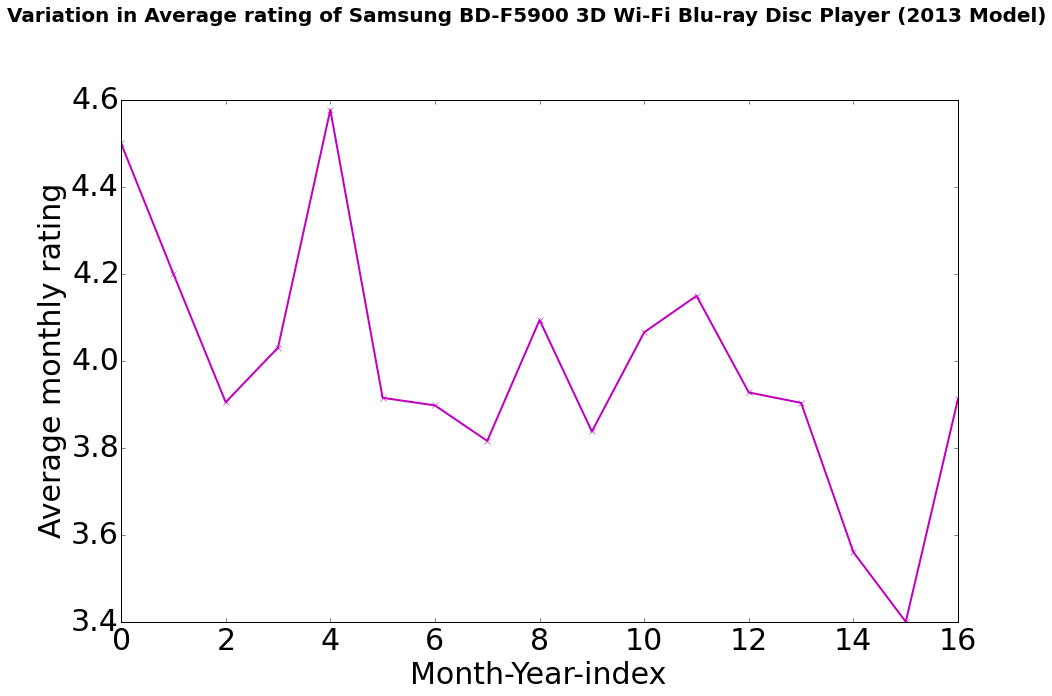

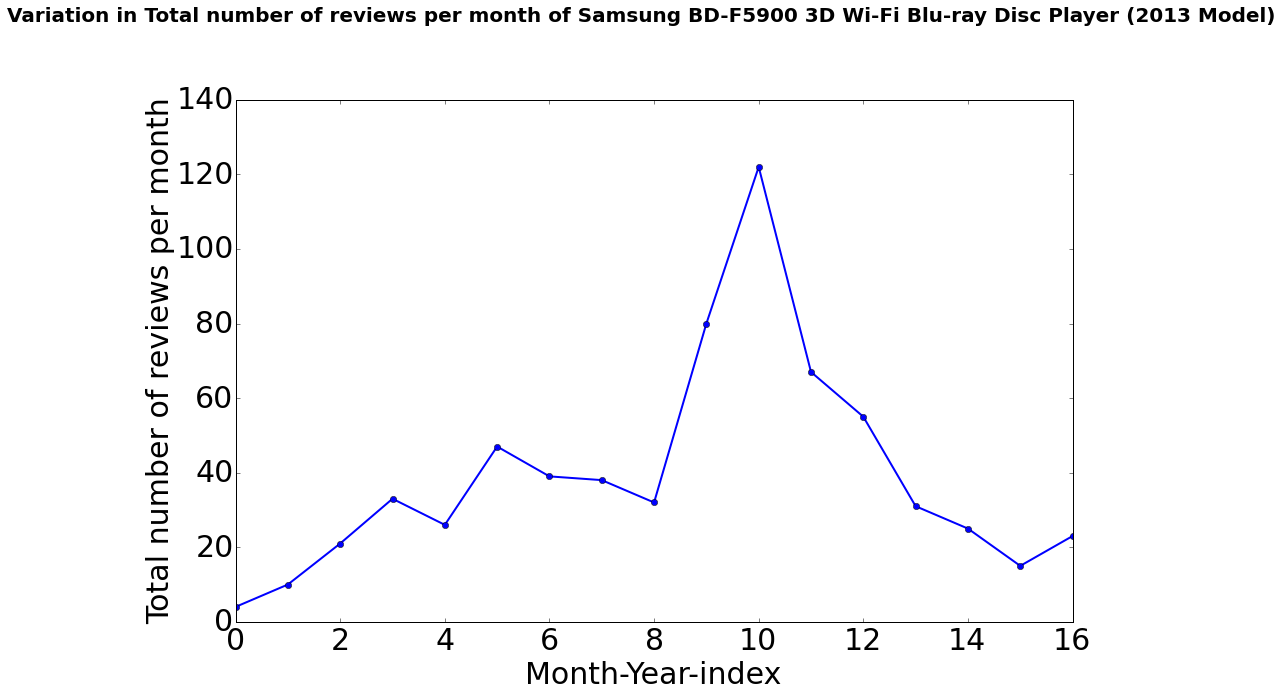

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B00BFDHVAS |      3      |    2013    |   4   |      4.5       | ... |
| B00BFDHVAS |      4      |    2013    |   10  |      4.2       | ... |
| B00BFDHVAS |      5      |    2013    |   21  | 3.90476190476  | ... |
| B00BFDHVAS |      6      |    2013    |   33  |  4.0303030303  | ... |
| B00BFDHVAS |      7      |    2013    |   26  | 4.57692307692  | ... |
| B00BFDHVAS |      8      |    2013    |   47  | 3.91489361702  | ... |
| B00BFDHVAS |      9      |    2013    |   39  | 3.89743589744  | ... |
| B00BFDHVAS |      10     |    2013    |   38  | 3.81578947368  | ... |
| B00BFDHVAS |      11     |    2013    |   32  |    4.09375     | ... |
| B00BFDHVAS |      12     |    2013    |   80  |     3.8375     | ... |
| B00BFDHVAS |      1      |    2014    |  122  | 4

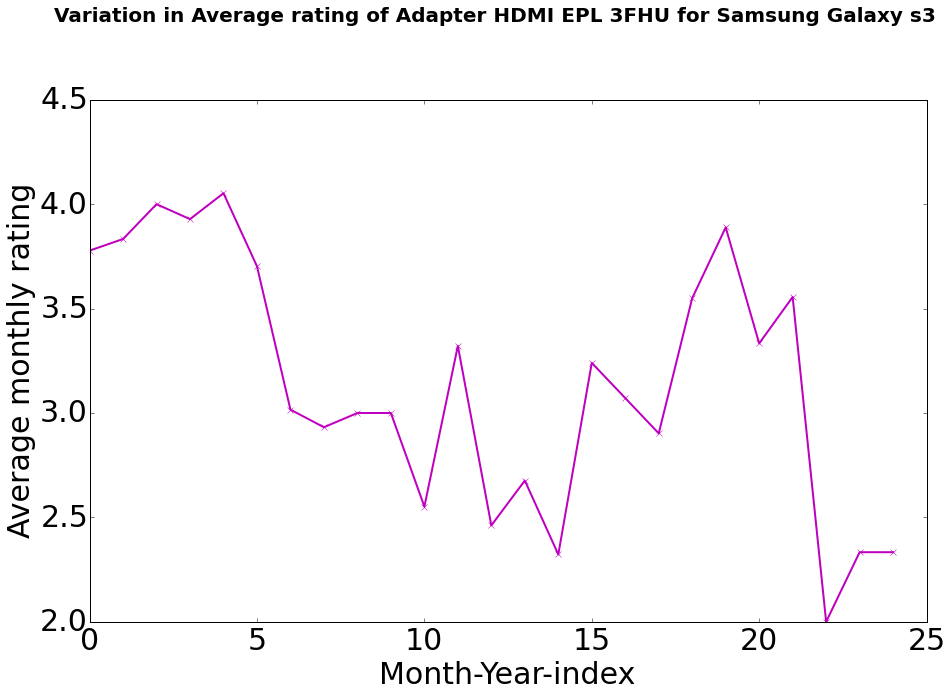

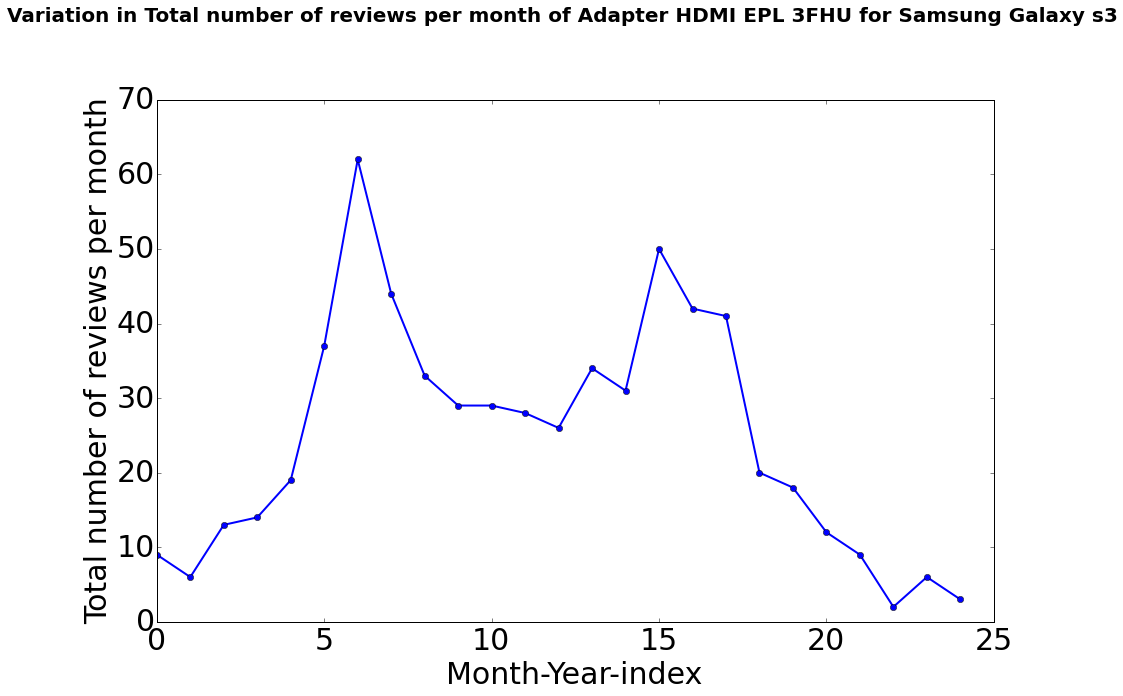

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0080CXSOU |      7      |    2012    |   9   | 3.77777777778  | ... |
| B0080CXSOU |      8      |    2012    |   6   | 3.83333333333  | ... |
| B0080CXSOU |      9      |    2012    |   13  |      4.0       | ... |
| B0080CXSOU |      10     |    2012    |   14  | 3.92857142857  | ... |
| B0080CXSOU |      11     |    2012    |   19  | 4.05263157895  | ... |
| B0080CXSOU |      12     |    2012    |   37  |  3.7027027027  | ... |
| B0080CXSOU |      1      |    2013    |   62  | 3.01612903226  | ... |
| B0080CXSOU |      2      |    2013    |   44  | 2.93181818182  | ... |
| B0080CXSOU |      3      |    2013    |   33  |      3.0       | ... |
| B0080CXSOU |      4      |    2013    |   29  |      3.0       | ... |
| B0080CXSOU |      5      |    2013    |   29  | 2

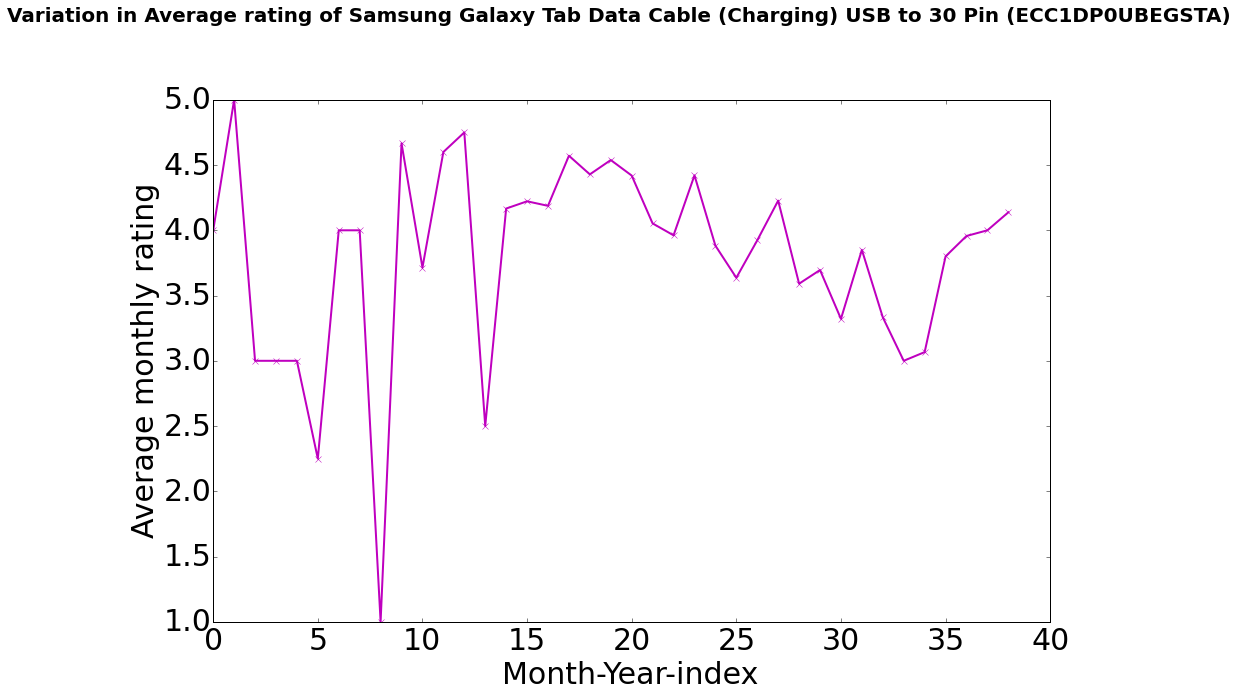

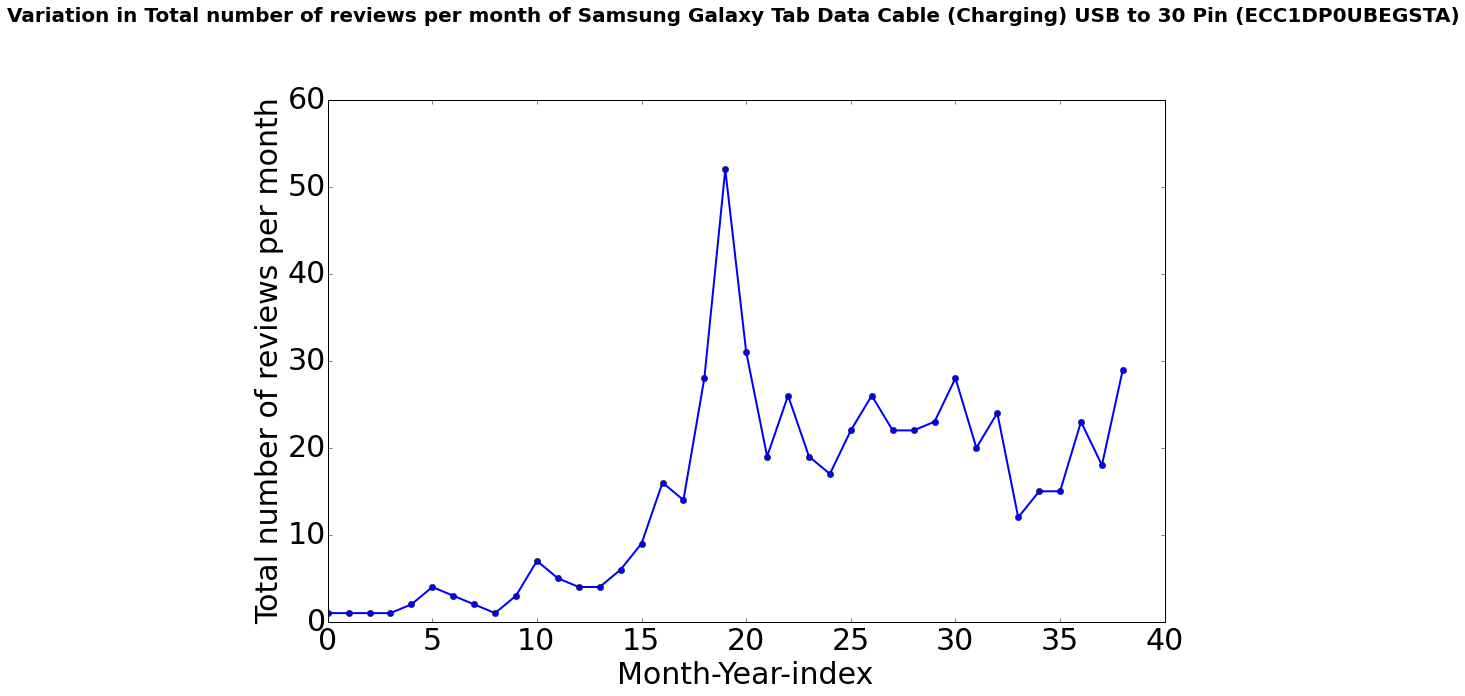

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004DBD4TG |      12     |    2010    |   1   |      4.0       | ... |
| B004DBD4TG |      1      |    2011    |   1   |      5.0       | ... |
| B004DBD4TG |      3      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      5      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      6      |    2011    |   2   |      3.0       | ... |
| B004DBD4TG |      7      |    2011    |   4   |      2.25      | ... |
| B004DBD4TG |      8      |    2011    |   3   |      4.0       | ... |
| B004DBD4TG |      10     |    2011    |   2   |      4.0       | ... |
| B004DBD4TG |      11     |    2011    |   1   |      1.0       | ... |
| B004DBD4TG |      1      |    2012    |   3   | 4.66666666667  | ... |
| B004DBD4TG |      3      |    2012    |   7   | 3

In [15]:
#plots for negative products
ctr=-1
for i in items_of_int_n:
    ctr=ctr+1
    producthist= product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] 
                                                        == samsung_product_short_list[i]]
        
    timeline=range(len(producthist['Avg of overall']))
    
    fig = plt.figure(figsize=(15,10))

    figtitle='Variation in Average rating of'+' '+n_item_title_list[ctr]
  
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Average monthly rating',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Avg of overall']),'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
    plt.show()
    
    figtitle='Variation in Total number of reviews per month of'+' '+n_item_title_list[ctr]
   
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Total number of reviews per month',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Count']),'-bo',linewidth=2)
    
    plt.show()
    
    producthist.print_rows(num_rows=5000, num_columns=5)
    
    del producthist

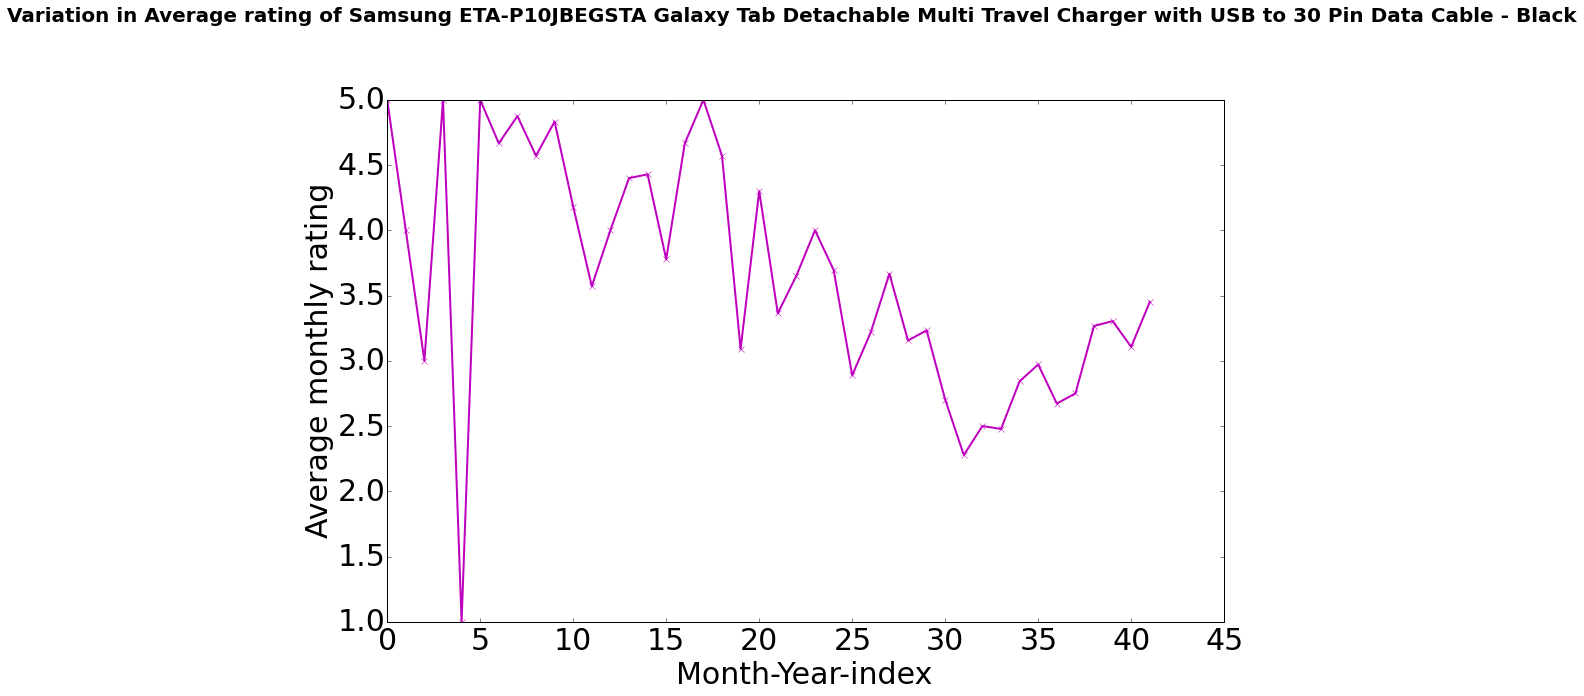

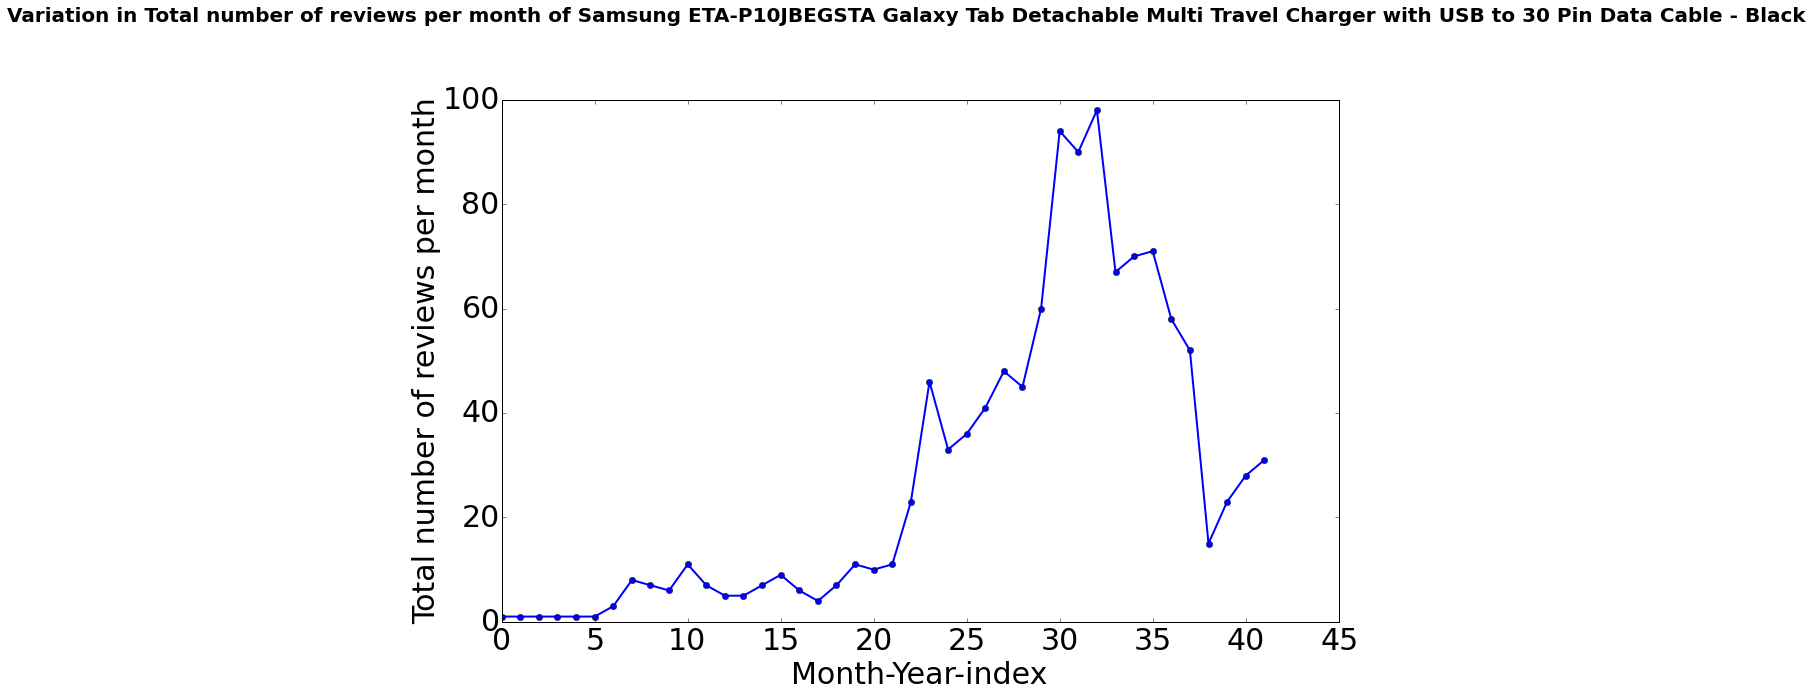

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004CGHDEO |      12     |    2010    |   1   |      5.0       | ... |
| B004CGHDEO |      1      |    2011    |   1   |      4.0       | ... |
| B004CGHDEO |      2      |    2011    |   1   |      3.0       | ... |
| B004CGHDEO |      3      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      6      |    2011    |   1   |      1.0       | ... |
| B004CGHDEO |      7      |    2011    |   1   |      5.0       | ... |
| B004CGHDEO |      8      |    2011    |   3   | 4.66666666667  | ... |
| B004CGHDEO |      9      |    2011    |   8   |     4.875      | ... |
| B004CGHDEO |      10     |    2011    |   7   | 4.57142857143  | ... |
| B004CGHDEO |      11     |    2011    |   6   | 4.83333333333  | ... |
| B004CGHDEO |      12     |    2011    |   11  | 4

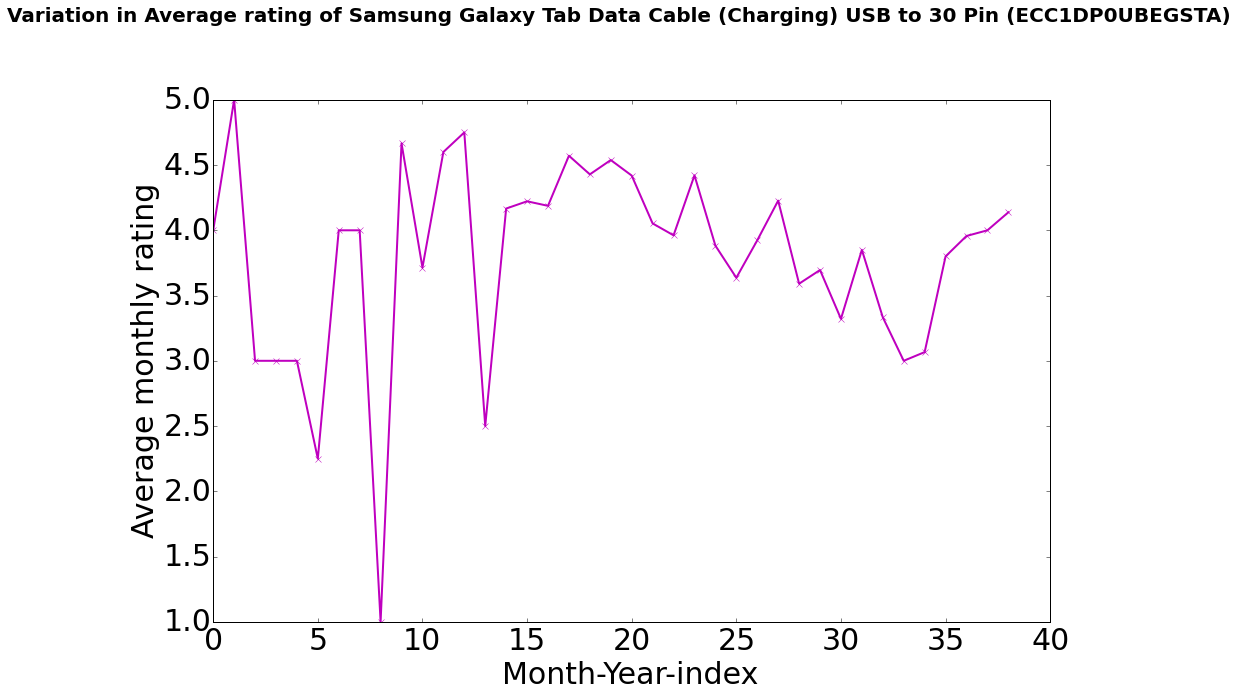

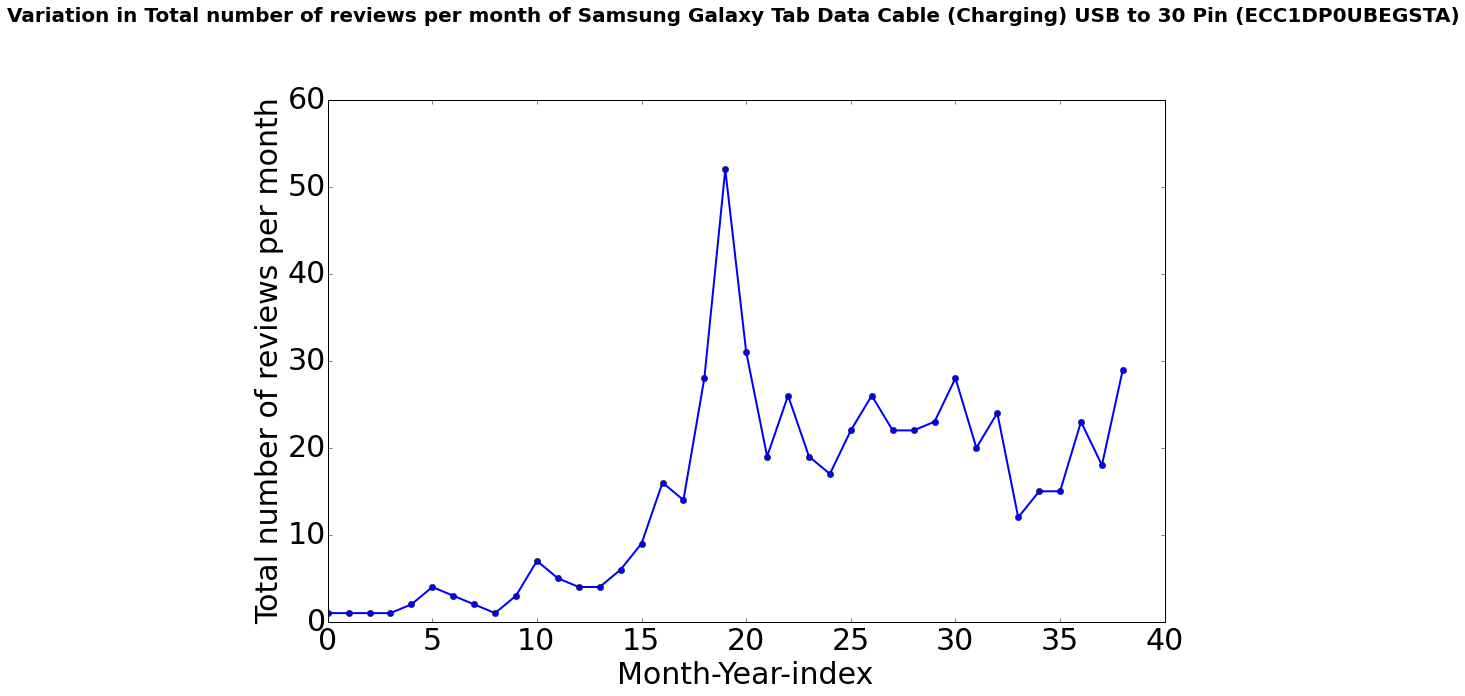

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B004DBD4TG |      12     |    2010    |   1   |      4.0       | ... |
| B004DBD4TG |      1      |    2011    |   1   |      5.0       | ... |
| B004DBD4TG |      3      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      5      |    2011    |   1   |      3.0       | ... |
| B004DBD4TG |      6      |    2011    |   2   |      3.0       | ... |
| B004DBD4TG |      7      |    2011    |   4   |      2.25      | ... |
| B004DBD4TG |      8      |    2011    |   3   |      4.0       | ... |
| B004DBD4TG |      10     |    2011    |   2   |      4.0       | ... |
| B004DBD4TG |      11     |    2011    |   1   |      1.0       | ... |
| B004DBD4TG |      1      |    2012    |   3   | 4.66666666667  | ... |
| B004DBD4TG |      3      |    2012    |   7   | 3

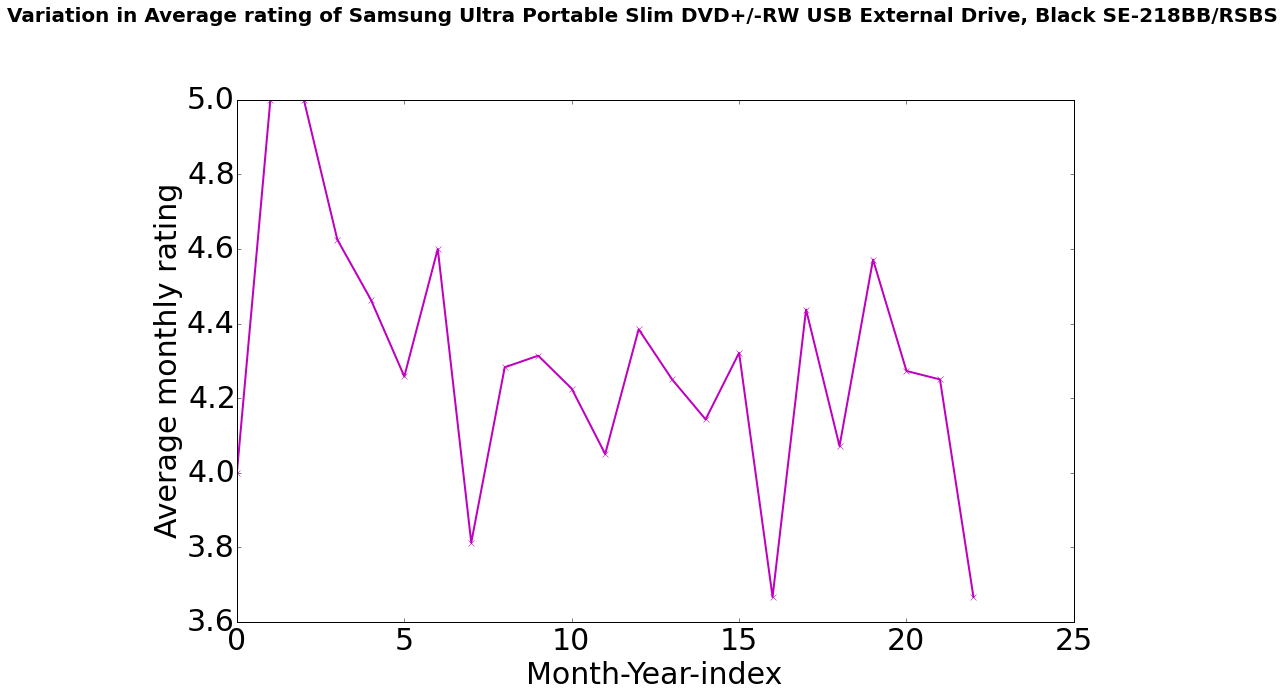

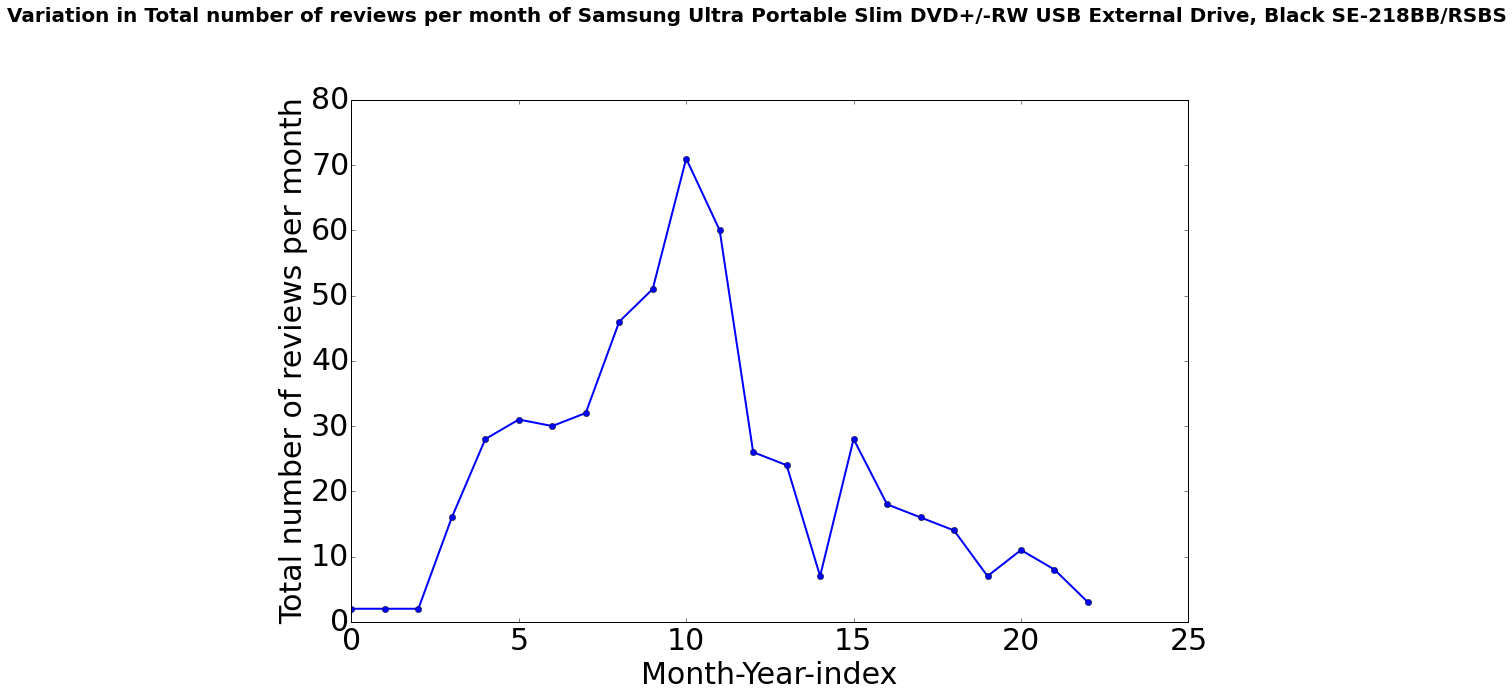

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B008AJLPYS |      9      |    2012    |   2   |      4.0       | ... |
| B008AJLPYS |      10     |    2012    |   2   |      5.0       | ... |
| B008AJLPYS |      11     |    2012    |   2   |      5.0       | ... |
| B008AJLPYS |      12     |    2012    |   16  |     4.625      | ... |
| B008AJLPYS |      1      |    2013    |   28  | 4.46428571429  | ... |
| B008AJLPYS |      2      |    2013    |   31  | 4.25806451613  | ... |
| B008AJLPYS |      3      |    2013    |   30  |      4.6       | ... |
| B008AJLPYS |      4      |    2013    |   32  |     3.8125     | ... |
| B008AJLPYS |      5      |    2013    |   46  | 4.28260869565  | ... |
| B008AJLPYS |      6      |    2013    |   51  |  4.3137254902  | ... |
| B008AJLPYS |      7      |    2013    |   71  | 4

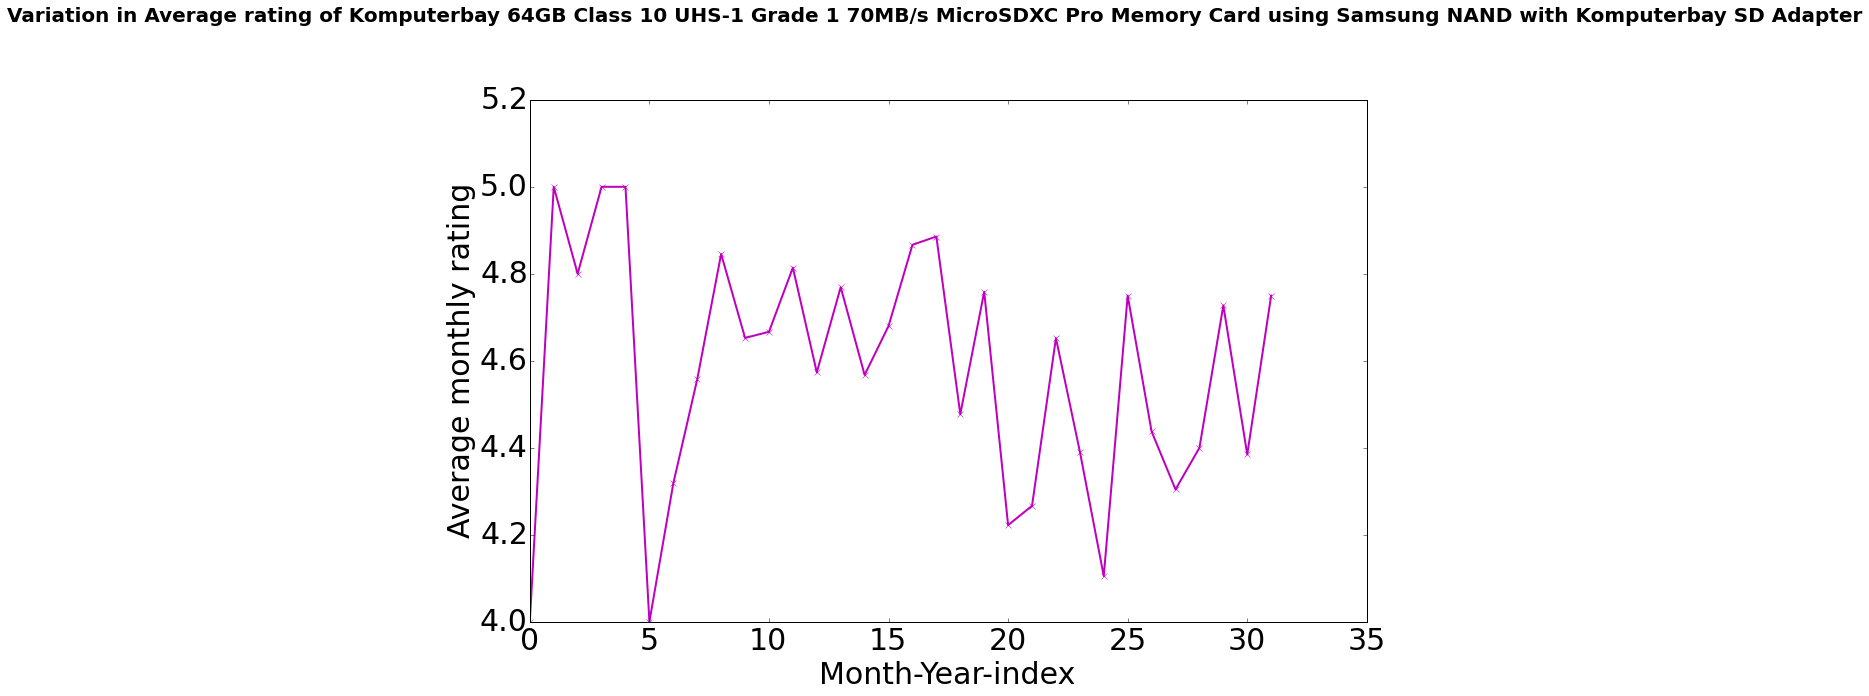

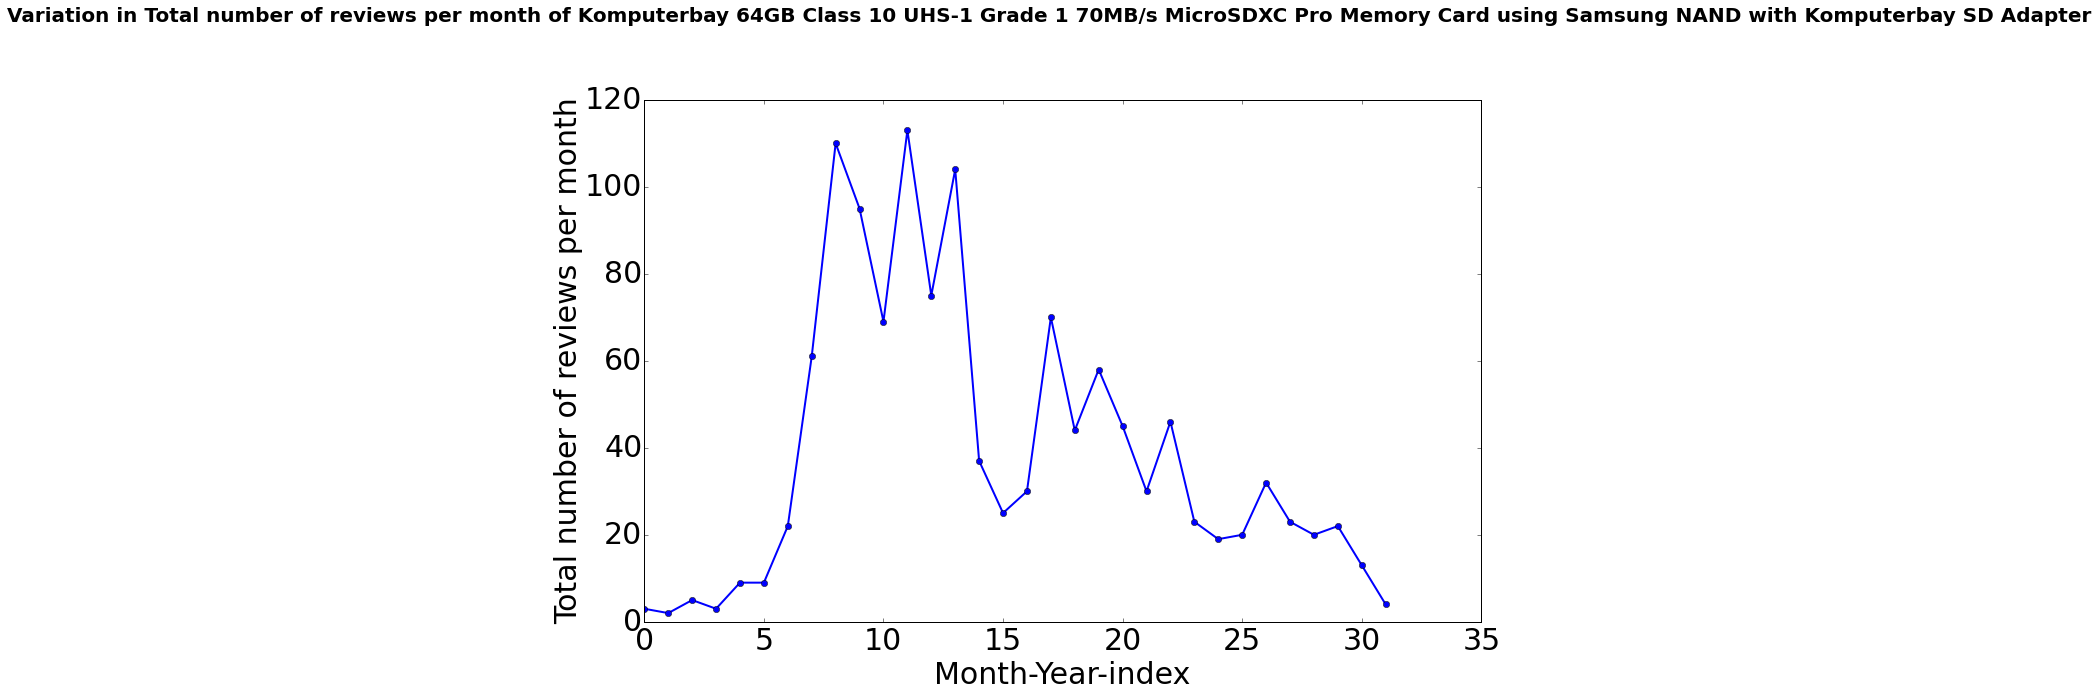

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B005VFG06W |      11     |    2011    |   3   |      4.0       | ... |
| B005VFG06W |      1      |    2012    |   2   |      5.0       | ... |
| B005VFG06W |      2      |    2012    |   5   |      4.8       | ... |
| B005VFG06W |      3      |    2012    |   3   |      5.0       | ... |
| B005VFG06W |      4      |    2012    |   9   |      5.0       | ... |
| B005VFG06W |      5      |    2012    |   9   |      4.0       | ... |
| B005VFG06W |      6      |    2012    |   22  | 4.31818181818  | ... |
| B005VFG06W |      7      |    2012    |   61  | 4.55737704918  | ... |
| B005VFG06W |      8      |    2012    |  110  | 4.84545454545  | ... |
| B005VFG06W |      9      |    2012    |   95  | 4.65263157895  | ... |
| B005VFG06W |      10     |    2012    |   69  | 4

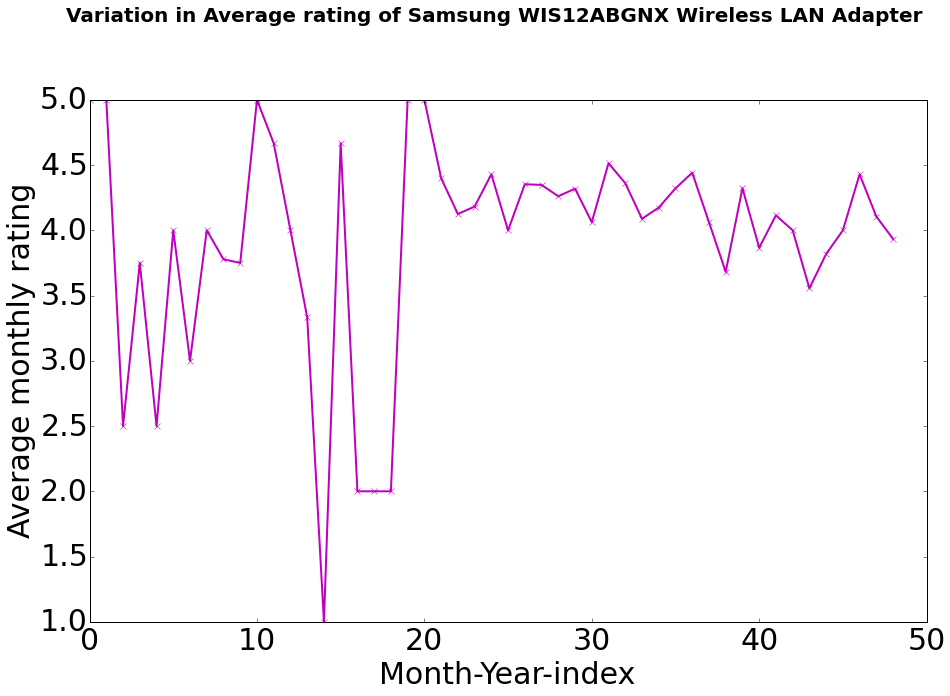

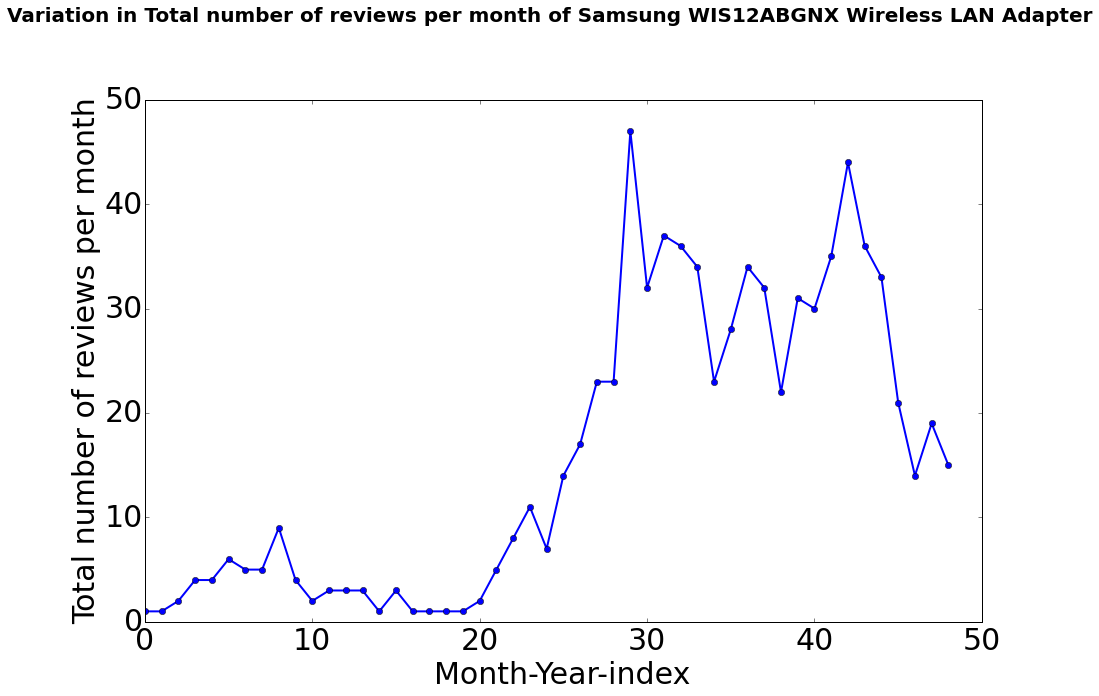

+------------+-------------+------------+-------+----------------+-----+
|    asin    | reviewmonth | reviewyear | Count | Avg of overall | ... |
+------------+-------------+------------+-------+----------------+-----+
| B0079KZZKO |      4      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      5      |    2010    |   1   |      5.0       | ... |
| B0079KZZKO |      6      |    2010    |   2   |      2.5       | ... |
| B0079KZZKO |      7      |    2010    |   4   |      3.75      | ... |
| B0079KZZKO |      8      |    2010    |   4   |      2.5       | ... |
| B0079KZZKO |      9      |    2010    |   6   |      4.0       | ... |
| B0079KZZKO |      10     |    2010    |   5   |      3.0       | ... |
| B0079KZZKO |      11     |    2010    |   5   |      4.0       | ... |
| B0079KZZKO |      12     |    2010    |   9   | 3.77777777778  | ... |
| B0079KZZKO |      1      |    2011    |   4   |      3.75      | ... |
| B0079KZZKO |      3      |    2011    |   2   |  

In [16]:
#plots for positive products
ctr=-1
for i in items_of_int_p:
    ctr=ctr+1
    producthist= product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin'] 
                                                        == samsung_product_short_list[i]]
        
    timeline=range(len(producthist['Avg of overall']))
    
    fig = plt.figure(figsize=(15,10))

    figtitle='Variation in Average rating of'+' '+p_item_title_list[ctr]
  
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Average monthly rating',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Avg of overall']),'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
    plt.show()
    
    figtitle='Variation in Total number of reviews per month of'+' '+p_item_title_list[ctr]
   
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(figtitle, fontsize=20, fontweight='bold')

    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

    ax.set_xlabel('Month-Year-index',fontsize=30)
    ax.set_ylabel('Total number of reviews per month',fontsize=30)
    for tick in ax.xaxis.get_major_ticks(): 
        tick.label.set_fontsize(30) 
    for tick in ax.yaxis.get_major_ticks(): 
        tick.label.set_fontsize(30)   


    ax.plot(timeline,list(producthist['Count']),'-bo',linewidth=2)
    
    plt.show()
    
    producthist.print_rows(num_rows=5000, num_columns=5)
    
    del producthist

In [81]:
##initialisation of product details
product_of_interest_id ='B004CGHDEO'
# 'B0079KZZKO'
month_start,year_start=12,2010
month_end,year_end=7,2014
total_month_start=month_start+12*year_start
total_month_end=month_end+12*year_end
itemframe=product_elec_rating_stats_samsung_sorted_shortlist[product_elec_rating_stats_samsung_sorted_shortlist['asin']
                                                                 == product_of_interest_id]
#product name

temp_title= elec_meta_data[elec_meta_data['asin']==product_of_interest_id ]['title']
##avoiding syntax issues
item_title= str(temp_title[0])

itemframe['cumulativemonths']=itemframe['reviewmonth']+12*itemframe['reviewyear']

itemframe=itemframe[(itemframe['cumulativemonths']>=total_month_start) & (itemframe['cumulativemonths']<=total_month_end) ]

elec_rev_data_item= elec_rev_data[elec_rev_data['asin'] == product_of_interest_id]

itemframe['fulldate']=itemframe['reviewmonth'].astype(str)+'-'+itemframe['reviewyear'].astype(str)

check=itemframe['fulldate']

xnew=list(check.str_to_datetime("%m-%Y"))

xvvnew=[item.date() for item in xnew]

y=list(itemframe['Avg of overall'])

y2=list(itemframe['Count'])
    ##extracting the reviews

check=elec_rev_data_item['reviewTime']
xnew=check.str_to_datetime("%m %-d, %Y")
elec_rev_data_item['reviewday']=xnew.split_datetime('',limit=['day'])['day']
elec_rev_data_item['reviewmonth']=xnew.split_datetime('',limit=['month'])['month']
elec_rev_data_item['reviewyear']=xnew.split_datetime('',limit=['year'])['year']
elec_rev_data_item['cumulativemonths']=elec_rev_data_item['reviewmonth']+12*elec_rev_data_item['reviewyear']
elec_rev_data_item_small=elec_rev_data_item[(elec_rev_data_item['cumulativemonths']>=total_month_start) & 
                                            (elec_rev_data_item['cumulativemonths']<=total_month_end) ]

item_rev_list=list(elec_rev_data_item_small['reviewText'])

In [82]:
len(item_rev_list)

1152

In [83]:
import re, string
from sklearn.feature_extraction.text import CountVectorizer 
from gensim.parsing.preprocessing import STOPWORDS

stopwords = list(STOPWORDS)

stopwords += ['.', ',', '(', ')', "'", '"']

univectorizer = CountVectorizer(ngram_range=(1,1))
unianalyzer = univectorizer.build_analyzer()
bivectorizer = CountVectorizer(ngram_range=(2,2))
bianalyzer = bivectorizer.build_analyzer()
trivectorizer = CountVectorizer(ngram_range=(3,3))
trianalyzer = trivectorizer.build_analyzer()

texts_uni = [re.sub('[%s]' % re.escape(string.punctuation), '', document.lower())
                  for document in item_rev_list]

texts_uni= [[word for word in document.lower().split() if word not in stopwords] for document in texts_uni]

texts_uni_join= [ " ".join(doc)for doc in texts_uni]



In [18]:
# texts_uni_join[0]

In [19]:
# texts_uni[0]

In [84]:
texts_bi= [bianalyzer(document) for document in texts_uni_join]

texts_tri= [trianalyzer(document) for document in texts_uni_join] 


    


In [21]:
# len(texts_tri)

[INFO] adding document #0 to Dictionary(0 unique tokens: [])
[INFO] built Dictionary(4244 unique tokens: [u'limited', u'rectangular tapers', u'vcast labels', u'charger day', u'hitch']...) from 1152 documents (total 29215 corpus positions)
[INFO] discarding 0 tokens: []...
[INFO] keeping 4134 tokens which were in no less than 2 and no more than 806 (=70.0%) documents
[INFO] resulting dictionary: Dictionary(4134 unique tokens: [u'limited', u'rectangular tapers', u'vcast labels', u'personally dont', u'hitch']...)
[INFO] saving Dictionary object under ./tmp/Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black_B004CGHDEO.dct, separately None
[INFO] storing corpus in Matrix Market format to ./tmp/Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cable - Black_B004CGHDEO.mm
[INFO] saving sparse matrix to ./tmp/Samsung ETA-P10JBEGSTA Galaxy Tab Detachable Multi Travel Charger with USB to 30 Pin Data Cabl

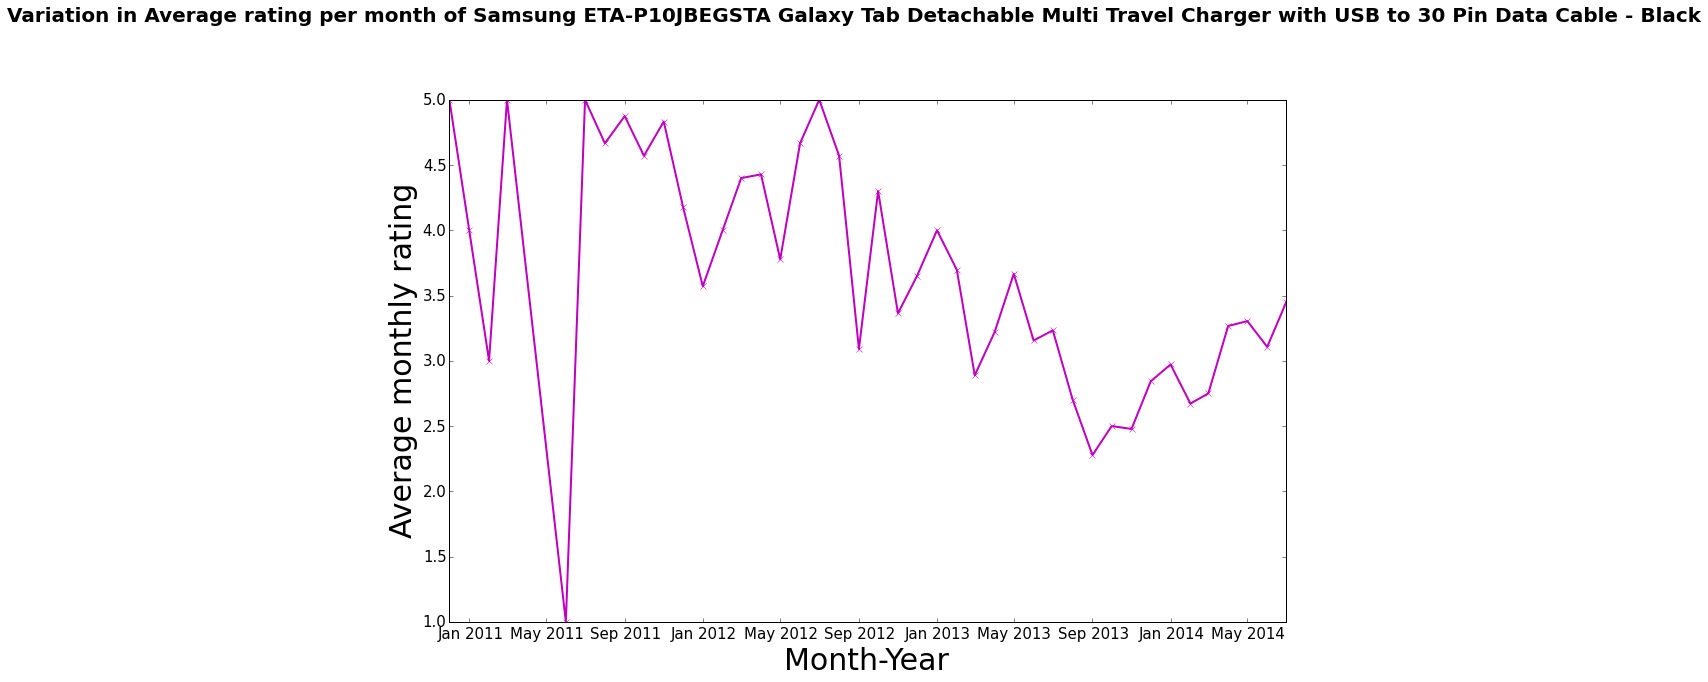

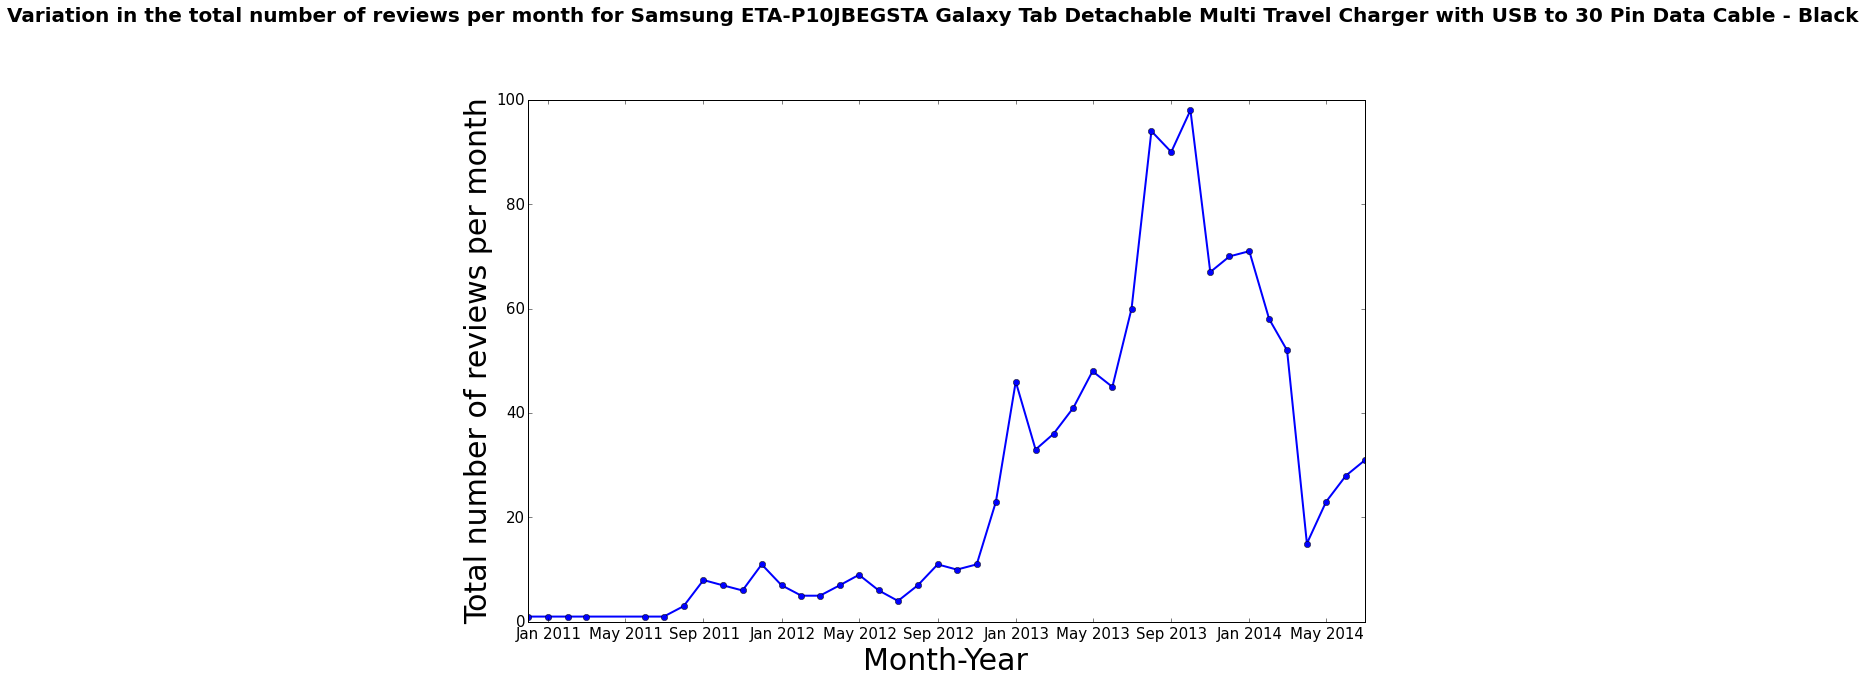

In [85]:
texts=[]
for i,j in enumerate(texts_tri):
    texts.append(texts_uni[i]+texts_bi[i]+ texts_tri[i])

# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
              for text in texts]

dictionary = corpora.Dictionary(texts)
    # remove stop words and words that appear only once
stop_ids = [dictionary.token2id[stopword] for stopword in stopwords
                if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.iteritems() if docfreq == 1]

dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once

dictionary.filter_extremes(no_below=2, no_above=0.7)# #remove extremes (similar to the min/max df step used when creating the tf-idf matrix)

dictionary.compactify() # remove gaps in id sequence after words that were removed
dctsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.dct'
dictionary.save(dctsavename)

    #creation of corpus
corpus = [dictionary.doc2bow(text) for text in texts]
corpsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.mm'
corpora.MmCorpus.serialize(corpsavename, corpus)

    #creation of model

model = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5,update_every=1,chunksize=100000, passes=10,iterations=100)

# model = hdpmodel.HdpModel(bow_corpus, id2word=dictionary)
    #saving lda model
modsavename= './tmp/'+ item_title +'_'+product_of_interest_id +'.lda'
model.save(modsavename)
model.show_topics()
    
fig = plt.figure(figsize=(15,10))

figtitle='Variation in Average rating per month of'+' '+item_title
  
fig.suptitle(figtitle, fontsize=20, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

ax.set_xlabel('Month-Year',fontsize=30)
ax.set_ylabel('Average monthly rating',fontsize=30)
for tick in ax.xaxis.get_major_ticks(): 
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks(): 
    tick.label.set_fontsize(15)   


ax.plot(xvvnew,y,'-mx',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
plt.show()
    
fig = plt.figure(figsize=(15,10))
figtitle='Variation in the total number of reviews per month for'+' '+item_title
  
fig.suptitle(figtitle, fontsize=20, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#     ax.set_title('axes title',fontsize=30)

ax.set_xlabel('Month-Year',fontsize=30)
ax.set_ylabel('Total number of reviews per month',fontsize=30)
for tick in ax.xaxis.get_major_ticks(): 
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks(): 
    tick.label.set_fontsize(15)   

ax.plot(xvvnew,y2,'-bo',linewidth=2)

#     ax.axis([0, 50, 0, 5.5])
plt.show()


In [86]:
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(model, corpus, dictionary)



PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      32.027066        1       1 -0.087069  0.027443
1      27.745148        1       2 -0.057859  0.011331
0      17.016763        1       3 -0.043910 -0.118252
2      12.656031        1       4  0.186165 -0.012860
4      10.554992        1       5  0.002672  0.092338, topic_info=     Category        Freq                Term  Total  loglift  logprob
3314  Default  264.000000              galaxy    264  30.0000  30.0000
3247  Default  223.000000                 tab    223  29.0000  29.0000
1998  Default  245.000000            original    245  28.0000  28.0000
3644  Default  147.000000          galaxy tab    147  27.0000  27.0000
16    Default   43.000000       like original     43  26.0000  26.0000
824   Default  181.000000                cord    181  25.0000  25.0000
2046  Default  214.000000               cable    214  24.0000  24.0000
773   Default   95.000000               apart     95  23.0000  23.0000
3757  Default  137.000000                 usb    137  22.0000  22.0000
2390  Default  212.000000                like    212  21.0000  21.0000
2599  Default   86.000000      samsung galaxy     86  20.0000  20.0000
945   Default   35.000000                fell     35  19.0000  19.0000
1970  Default  148.000000                time    148  18.0000  18.0000
176   Default  254.000000                work    254  17.0000  17.0000
1132  Default  153.000000                plug    153  16.0000  16.0000
1750  Default   74.000000               money     74  15.0000  15.0000
1114  Default   82.000000             working     82  14.0000  14.0000
1908  Default   27.000000          fell apart     27  13.0000  13.0000
2446  Default   36.000000             stopped     36  12.0000  12.0000
741   Default   65.000000                note     65  11.0000  11.0000
4025  Default  122.000000                 buy    122  10.0000  10.0000
1192  Default  286.000000             product    286   9.0000   9.0000
1421  Default   41.000000            note 101     41   8.0000   8.0000
3533  Default   66.000000              device     66   7.0000   7.0000
2765  Default   39.000000               plugs     39   6.0000   6.0000
493   Default  230.000000                came    230   5.0000   5.0000
345   Default  116.000000                 got    116   4.0000   4.0000
3568  Default   45.000000              longer     45   3.0000   3.0000
91    Default   45.000000  samsung galaxy tab     45   2.0000   2.0000
1021  Default  129.000000                item    129   1.0000   1.0000
...       ...         ...                 ...    ...      ...      ...
1123   Topic5   11.878465               going     31   1.1678  -5.6729
2497   Topic5    7.958000                port     17   1.3801  -6.0613
4025   Topic5   24.960363                 buy    122   0.5345  -4.9361
1114   Topic5   20.011444             working     82   0.6986  -5.1693
1730   Topic5   67.956725             charger    878  -0.4314  -3.9284
3757   Topic5   24.280943                 usb    137   0.4026  -4.9520
176    Topic5   34.097542                work    254   0.1069  -4.6304
824    Topic5   27.440968                cord    181   0.2275  -4.8486
2154   Topic5   32.816238              charge    298  -0.0847  -4.6622
2046   Topic5   26.898811               cable    214   0.0603  -4.8484
2401   Topic5   15.680258                wall     72   0.5952  -5.4028
2253   Topic5   11.432374               short     40   0.8769  -5.7088
1132   Topic5   20.749577                plug    153   0.1281  -5.1161
2803   Topic5   34.928461              tablet    514  -0.5574  -4.5898
3314   Topic5   25.165936              galaxy    264  -0.2061  -4.9048
3191   Topic5   20.961127                 use    163   0.0701  -5.1108
3568   Topic5   11.918891              longer     45   0.7723  -5.6957
4120   Topic5   25.565816             samsung    398  -0.6155  -4.9037
3247   Topic5   19.934863    

In [116]:
# data=pyLDAvis.gensim.prepare(model, corpus, dictionary)
# pyLDAvis.save_html(data, 'pyldavis_koj_final_tp_1_5.html')
# !python -m SimpleHTTPServer 8000

In [87]:
#clustering the documents according to their content
corpus_lda = model[corpus]
doc_dict={}
for docid,doc in enumerate(corpus_lda): 
    print doc
    doc_topics=[item[0] for item in doc]
    doc_topic_prob=[item[1] for item in doc]
    doc_dict[docid]=[doc_topics,doc_topic_prob]
    
        

    
    
            
            
            
            
            
            
            
            

[(0, 0.79609298133926309), (1, 0.051417607490207802), (2, 0.050781787815422127), (3, 0.050999114950668507), (4, 0.050708508404438656)]
[(0, 0.018274150861527564), (1, 0.29930638969087525), (2, 0.01836096560608607), (3, 0.64568056828341081), (4, 0.018377925558100354)]
[(0, 0.020184813937260328), (1, 0.91835644264466687), (2, 0.020138669658584803), (3, 0.02090671626860437), (4, 0.020413357490883615)]
[(0, 0.97295422099497342)]
[(0, 0.018559496622793947), (1, 0.92593675664702579), (2, 0.018408187930017056), (3, 0.018669004387478171), (4, 0.018426554412685078)]
[(0, 0.02905047363886545), (1, 0.029177494263573928), (2, 0.028726741830274117), (3, 0.88327211264765282), (4, 0.029773177619633658)]
[(0, 0.29431319593548244), (1, 0.015624720068561868), (2, 0.015539380323394117), (3, 0.015637643313240988), (4, 0.6588850603593206)]
[(1, 0.98063026858331459)]
[(1, 0.96594456498611925)]
[(0, 0.95927603814204121), (1, 0.010261237397840382), (2, 0.010076828729267675), (3, 0.010303571849312623), (4, 0.0

In [88]:
###classifying each document as belonging to 
import operator

topic_0_docs_idx=[]
topic_1_docs_idx=[]
topic_2_docs_idx=[]
topic_3_docs_idx=[]
topic_4_docs_idx=[]

for k,v in doc_dict.items():
    topicslist=v[0]
    problist=v[1]
    max_index, max_value = max(enumerate(problist), key=operator.itemgetter(1))
    topic_index=topicslist[max_index]
    if topic_index==0:
        topic_0_docs_idx.append(k)
    elif topic_index==1:
        topic_1_docs_idx.append(k)
    elif topic_index==2:
        topic_2_docs_idx.append(k)        
    elif topic_index==3:
        topic_3_docs_idx.append(k)
    elif topic_index==4:
        topic_4_docs_idx.append(k)
    
    

In [112]:
dict_vec={}
dict_vec[0]=0
dict_vec[1]=0
dict_vec[2]=0
dict_vec[3]=0
dict_vec[4]=0
mag0,mag1,mag2,mag3,mag4=0,0,0,0,0
for item in topic_4_docs_idx:

        for idx,z in enumerate(doc_dict[item][0]):

                 dict_vec[z]+=doc_dict[item][1][idx]
print dict_vec
#         print components
#         print magnitudes


{0: 3.12095361586884, 1: 2.7058232583015038, 2: 2.0050014619931731, 3: 4.4629636623956337, 4: 99.646232688227911}


In [103]:
print len(topic_0_docs_idx),len(topic_1_docs_idx),len(topic_2_docs_idx),len(topic_3_docs_idx),len(topic_4_docs_idx)

243 320 79 397 113


In [113]:
vec_lda=[]
for k,v in dict_vec.items():
    vec_lda.append((k,v))
print vec_lda
print 

#  query in LDA space
# vec_lda=
index = similarities.MatrixSimilarity(model[corpus],num_features=5) # transform corpus to LDA space and index it
sims = index[vec_lda] # perform a similarity query against the corpus
# print(list(enumerate(sims))) # print (document_number, document_similarity) 2-tuples
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims) # print sorted (document number, similarity score) 2-tuples

[INFO] creating matrix for 1152 documents and 5 features


[(0, 3.12095361586884), (1, 2.7058232583015038), (2, 2.0050014619931731), (3, 4.4629636623956337), (4, 99.646232688227911)]

[(311, 0.99983382), (597, 0.99983001), (974, 0.99983001), (470, 0.9998244), (305, 0.99977767), (592, 0.99976534), (598, 0.99976343), (895, 0.99976289), (1063, 0.99970144), (981, 0.99968582), (836, 0.99961871), (139, 0.99961084), (371, 0.99960482), (734, 0.9996044), (727, 0.99960071), (947, 0.99953359), (65, 0.99952763), (254, 0.99952662), (788, 0.9995209), (1139, 0.99951881), (313, 0.99951595), (567, 0.99945766), (462, 0.99945021), (956, 0.99944997), (880, 0.99944937), (669, 0.99944562), (728, 0.99944144), (498, 0.99944055), (68, 0.99943936), (149, 0.99943691), (991, 0.99938285), (839, 0.99937665), (361, 0.99937636), (390, 0.99937004), (965, 0.99937004), (277, 0.9993692), (684, 0.99936652), (404, 0.99936414), (246, 0.9993118), (935, 0.99930185), (946, 0.99930036), (889, 0.99923426), (445, 0.99923289), (520, 0.99923253), (750, 0.99923044), (725, 0.9991433), (1062,

In [114]:
#58-t0,28-t1,92-t2,77-t3,81-t4
#48-t0, 90-t1, 557-t2, -t3,-t4
#654-t0,429-t1,t2-970,t3-779,331-t4

item_rev_list[331]


'I wish to join the crowd of people that received a faulty AC adapter. It was a Samsung and it did look like the original. When you think of all the power problems associated with the Samsung Tablet I wonder if this AC adapter is not the cause of most of most of these problems. The low cost alone says there trying to get rid of these things. There are much better power adapters out there.'

In [ ]:
topic 0:'I received two different chargers and neither one of them worked.'
topic 1: 'What is taking so long?  Will let you know when it gets here if I get it within the timeline.'
topic 2: '"Good, but didn't last enough for the people to used.'
topic 3: "What can I see, it does as expected and does it to perfection.  It is, after all, Samsung's brand charger!"
topic 4: 'I wish to join the crowd of people that received a faulty AC adapter.It was a Samsung and it did look like the original. When you think of all the power problems associated 
        with the Samsung Tablet I wonder if this AC adapter is not the cause of most of most of these problems.
        The low cost alone says there trying to get rid of these things. There are much better power adapters out there.'
    

In [ ]:
# Topic 0: "Works great with my  UN40D6400.  Much cheaper here than in stores, if you can even find
#     it in stores. This model works flawlessly with my TV, regardless of what Samsung's site indicates.
#     Using a Netgear WNDR4500 router. Netflix is not discernably different with this adapter vs wired 
#     to the router."

# Topic 1:'The device worked like a charm when located where my Wireless G coverage was available.
# It did not work where my wireless coverage was very weak.  I suspect that Wireless N might
# have extended the coverage, but I found other solutions to the problem.'

# Topic 2: "i have a 42 inch lcd and a 60inch led, both smart tv's. great plug and play setupPros.
#     works on both 5ghz and 2.4ghz freq and is a,b,g,n; also not noticeable lag.will order another
#     as soon as i pay off my credit cardCons. price should have been $20"

# Topic 3: 'I have two of this wireless adapter and work perfect, if you see the value is to high in 
#     store you can bay in amazon.com for 50 bucks. samsung is very good brand, rely good.'
    
# Topic 4: "This doesn't work!  WHEN it connects it makes your computer a server and puts a terrible strain on your resources! 
#     I bought the wireless LAN for my Panasonic Blu Ray player, just plugged it and was connected!" 

In [ ]:
# Topic 0: 'I CANCELLED THE ORDER SO I CANT DO A REVIEW ON IT ...BUT ITS AN ADAPTER HOW BAD CAN IT BE'
# Topic 1: 'Worked once and never worked again. Now too late to return. I am so disappointed with this device, frustrated with it.'
# Topic 2: 'Works as advertised...no brainer!  If it appears to get &#34;hung up....frozen...taking longer than it should&#34; just turn
#           off the television...chances are it will have completed the upgrade!
# Topic 3: 'works great !! thanks .'
# Topic 4: 'IT DOES NOT WORK WITH MY TVSO I WAST MONEY ON IT. i SHOULD HAVE BOUGHT SOMETHING ELSE.I WISH I COULD GET A REFUND'

In [115]:
# 14 25 15 26 13 out of 93 docs in total
# 142 221 159 49 116 in 687 docs in total
# for i in topic_4_docs_idx:
#     print item_rev_list[i]
#     print 
# from sklearn.feature_extraction.text import TfidfVectorizer

# synopses=["This is very strange",
#           "any pig strange"]
# #define vectorizer parameters
# tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

# print(tfidf_matrix)
# print dict(zip(vectorizer.get_feature_names(), idf))

In [ ]:

# Sometimes takes a couple minutes to find the wireless signal after turning tv on, but it works. No complaints otherwise and still worth the $$$.

# So if you are an apple user and have all your music loaded on itunes on your MAC it doesn't work.  It's not intelligent enough to work with all types of computer. This thing is only set up for PC users ;-((  Not cool!!!

# It did not meet my expectation on buying this Samsung Wireless Lan adaptor. It did connect to my network but then on streaming video it just hang up most of the time. The advisory said that my wireless connection is very poor. What i did is i purchase a 50ft long cable which cost me 20 dollars, connected it by wire. It was a little bit of work but it serve the purpose and it work flawlessly. Now I am enjoying internet tv more. It just a waste of money investing on this kind of gadget.

# It is too bad that I bought the Samsung Blu-Ray Disk Player only to later learn that it required this adapter before it would connect wirelessly.  The adapter was received in a timely fashion and it does work as advertised.

# I ran into issues getting the wireless dongle to work correctly.  After several attempts and some searching I found that setting my wireless security to WPA on my wireless router and using a password key &lt; 10 characters solved it. Previous to this, I would get the error message that said "Physical connection establish but cannot connect to external network".

# I bought a samsung Blueray player a week ago and then came to find that it does not have built in wi-fi... so i had to order this lan adapter. It Works great havn't had any problems, it was very easy to set up just plug it i and then just connect to your wireless router through wi-fi.  And i got mine to me within 3 days they shipped very fast too...

# The most important thing to mention about this dongle is that it does not work on Samsung TVs.  It does, however, work with Samsung blu-ray players.  I have had no issues with it on any of the web apps available.  It is flawless in terms of netflix streaming and is very easy to set up.  Overall a good purchase at a lower price than the WIS09ABGN.

# I'm sorry to give this a bad review, I really want to give a good one but can't.  My "wireless ready" blu-ray player required this unit to work, I wanted to use this to stream Netflix movies to my TV but it would never pass the internet service test.  I updated the firmware on the player to the latest revision but it still wouldn't work.  I sent the wireless unit back for a refund and I ended up running a cat5 cable back to my router.  The unit still failed the internet service test.  Frustrated, I tried Netflix anyway and lo and behold it worked for whatever reason.  I didn't really try Netflix with the wireless dongle like I did with the cat5 cable, at the time I assumed that without it passing the internet service test it would obviously not connect.  Regardless, with cat5 cable Pandora doesn't work because it says there is no internet connection (??!!??).  I'm not sure that this setup is ready for prime-time.  It's obviously a problem with the player, so perhaps I didn't give the wireless dongle a fair shake...but it was supposed to work with my unit.  Whatever the problem, it was a frustrating experience as I'm an IT person and couldn't get it to work after about 4 hours of trying.  For those of you with the Xbox 360, you might find that this is a better solution for streaming Netflix to your TV, as it literally took 10 minutes to get it working just fine.  This is also the case for a Wii that I recently used to stream Netflix.

# Opened the box, Powered up my Blue Ray player, plugged it in - was prompted for my wireless encryption key, saved it an have been streaming hi-quality Netflix ever since.  Don't even know its there.Very nice unit - very simple to install.

# This adaptor did not work with my 2009 Samsung Blu Ray player as it said it would.  Return was easy and the model number without the 2 was ordered (~$10 more) and works fine.  Be sure and get the adaptor that the equipment user instructions call for and don't go by ads.

# We purchased the LAN adapter for use with our new Samsung LED Tv. It has opened up a whole new avenue for us. Being able to connect to the internet wirelessly  and watch countless youtube and netflix videos among many others is just awesome... The only con is the cost of the product..however we found it the cheapest at Amazon...elsewhere it was alteast 30 dollars more than the price at Amazon...Very happy with the purchase.

# This doesn't work!  WHEN it connects it makes your computer a server and puts a terrible strain on your resources!  I bought the wireless LAN for my Panasonic Blu Ray player, just plugged it and was connected!

# I chatted with Samsung online. The WIS12ABGNX is compatible with the WIS09AGBN.And it's HALF THE PRICE!!!!!! Can't wait to get it and start using it!


In [107]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# corpus = ["This is very strange",
#           "This is very nice"]
# vectorizer = TfidfVectorizer(min_df=1)
# X = vectorizer.fit_transform(corpus)
# idf = vectorizer.idf_
# print dict(zip(vectorizer.get_feature_names(), idf))

In [27]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# x=[1,2,3,4,5]
# y=[1,3,5,7,9]

# plt.figure(figsize=(25,15))
# plt.xlabel('Month-Year',fontsize=14)
# plt.ylabel('Total # of Reviews/Month')
# plt.plot(x, y,'-bo', linewidth=2)#-rd

In [7]:
t1,t2,t3,t4,t5=654,429,970,779,331
tot=t1+t2+t3+t4+t5
tot=float(tot)

In [11]:
t1p,t2p,t3p,t4p,t5p=float(t1*100/tot),t2*100/tot,t3*100/tot,t4*100/tot,t5*100/tot

In [12]:
t1p,t2p,t3p,t4p,t5p

(20.676572873853935,
 13.56307303193171,
 30.66708820739804,
 24.628517230477396,
 10.46474865633892)